# Preprocess data

In [184]:
import os
import shutil
import sys

import json

import numpy as np
from scipy import sparse
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sn
sn.set()

import pandas as pd
import implicit

from tqdm.notebook import tqdm

In [185]:
# Just choose the name of the dataset directory
dataset  = 'ml-20m'
DATA_DIR = '/Users/tomas/Documents/FEUP/Tese/data/' + dataset
PARSE_DATA_DIR = os.path.join(DATA_DIR, 'processed_70_10_20')

In [198]:
raw_data = pd.read_csv(os.path.join(DATA_DIR, 'ratings.csv'), header=0)

In [199]:
# binarize the data (only keep ratings >= 4)
raw_data = raw_data[raw_data['rating'] > 3.5]

In [200]:
raw_data.head()

,userId,movieId,rating,timestamp
6,1,151,4.0,1094785734
7,1,223,4.0,1112485573
8,1,253,4.0,1112484940
9,1,260,4.0,1112484826
10,1,293,4.0,1112484703


In [201]:
raw_data.shape

(9995410, 4)

### Clean

To have good amount of feedback, item at least with 10 clicks, and users with at least 10 ratings. I will split the data using the following approach. For each user i will use 80% to train, 10% to validation and 10 % to test. In this way in the future i can have a good foundation to use in my work.

In [189]:
# Count the number of unique items/users
# returns id, count 
def get_count(tp, id):
    playcount_groupbyid = tp[[id]].groupby(id, as_index=False)
    count = playcount_groupbyid.size()
    return count

In [190]:
# Triplet: user_id, item_id, rating
def filter_triplets(tp, min_uc=10, min_sc=10):
    
    # Only keep the triplets for items which were clicked on by at least min_sc users (10). 
    if min_sc > 0:
        itemcount = get_count(tp, 'movieId')
        tp = tp[tp['movieId'].isin(itemcount.index[itemcount >= min_sc])]
    
    # Only keep the triplets for users who clicked on at least min_uc items (10)
    # After doing this, some of the items will have less than min_uc users, but should only be a small proportion
    if min_uc > 0:
        usercount = get_count(tp, 'userId')
        tp = tp[tp['userId'].isin(usercount.index[usercount >= min_uc])]
    
    # Update both usercount and itemcount after filtering
    usercount, itemcount = get_count(tp, 'userId'), get_count(tp, 'movieId') 
    return tp, usercount, itemcount

In [202]:
raw_data, user_activity, item_popularity = filter_triplets(raw_data)

In [203]:
sparsity = 1. * raw_data.shape[0] / (user_activity.shape[0] * item_popularity.shape[0])

print("After filtering, there are %d watc hing events from %d users and %d movies (sparsity: %.3f%%)" % 
      (raw_data.shape[0], user_activity.shape[0], item_popularity.shape[0], sparsity * 100))

After filtering, there are 9911968 watc hing events from 129757 users and 11518 movies (sparsity: 0.663%)


In [204]:
raw_data.shape

(9911968, 4)

In [205]:
unique_uid = user_activity.index
unique_sid = item_popularity.index 

In [169]:
item_popularity.head()

movieId
1    32764
2     7249
3     3930
4      691
5     3209
dtype: int64

In [206]:
t = pd.DataFrame() 
t.columns

Index([], dtype='object')

In [232]:
for (i, uid) in enumerate(unique_uid):
    print(uid,i)
    

1 0
2 1
3 2
4 3
5 4
6 5
7 6
8 7
9 8
10 9
11 10
12 11
13 12
14 13
15 14
16 15
17 16
18 17
19 18
20 19
21 20
22 21
23 22
24 23
25 24
26 25
27 26
29 27
31 28
32 29
33 30
34 31
35 32
37 33
38 34
39 35
40 36
41 37
42 38
43 39
44 40
45 41
46 42
47 43
48 44
49 45
50 46
51 47
53 48
54 49
55 50
56 51
57 52
58 53
59 54
60 55
61 56
62 57
63 58
64 59
65 60
66 61
67 62
68 63
69 64
70 65
71 66
72 67
73 68
74 69
75 70
76 71
77 72
78 73
79 74
80 75
81 76
82 77
83 78
84 79
85 80
86 81
88 82
89 83
90 84
91 85
92 86
93 87
96 88
97 89
98 90
99 91
100 92
101 93
102 94
103 95
104 96
105 97
106 98
107 99
108 100
109 101
110 102
111 103
112 104
113 105
114 106
115 107
116 108
117 109
118 110
119 111
120 112
121 113
122 114
124 115
125 116
126 117
127 118
128 119
129 120
130 121
131 122
132 123
133 124
134 125
135 126
136 127
137 128
138 129
139 130
140 131
141 132
142 133
143 134
144 135
145 136
147 137
148 138
149 139
150 140
151 141
152 142
153 143
154 144
155 145
156 146
157 147
158 148
159 149
160 150
162

1584 1490
1586 1491
1587 1492
1588 1493
1589 1494
1590 1495
1591 1496
1592 1497
1593 1498
1595 1499
1596 1500
1597 1501
1598 1502
1599 1503
1600 1504
1601 1505
1602 1506
1603 1507
1604 1508
1605 1509
1606 1510
1607 1511
1608 1512
1609 1513
1610 1514
1611 1515
1612 1516
1613 1517
1614 1518
1615 1519
1616 1520
1617 1521
1618 1522
1619 1523
1620 1524
1621 1525
1622 1526
1623 1527
1624 1528
1625 1529
1626 1530
1627 1531
1628 1532
1629 1533
1630 1534
1631 1535
1632 1536
1633 1537
1634 1538
1636 1539
1637 1540
1638 1541
1639 1542
1640 1543
1641 1544
1642 1545
1643 1546
1644 1547
1645 1548
1647 1549
1648 1550
1649 1551
1650 1552
1651 1553
1652 1554
1653 1555
1654 1556
1655 1557
1656 1558
1657 1559
1658 1560
1659 1561
1660 1562
1661 1563
1662 1564
1664 1565
1665 1566
1666 1567
1667 1568
1668 1569
1669 1570
1670 1571
1671 1572
1672 1573
1673 1574
1674 1575
1675 1576
1676 1577
1677 1578
1678 1579
1679 1580
1680 1581
1682 1582
1683 1583
1684 1584
1685 1585
1686 1586
1687 1587
1688 1588
1689 1589


3209 2989
3210 2990
3211 2991
3212 2992
3213 2993
3214 2994
3215 2995
3216 2996
3217 2997
3218 2998
3219 2999
3220 3000
3221 3001
3222 3002
3223 3003
3224 3004
3225 3005
3226 3006
3227 3007
3228 3008
3229 3009
3230 3010
3231 3011
3233 3012
3235 3013
3236 3014
3237 3015
3238 3016
3239 3017
3240 3018
3241 3019
3242 3020
3243 3021
3244 3022
3245 3023
3246 3024
3247 3025
3248 3026
3249 3027
3250 3028
3251 3029
3252 3030
3253 3031
3254 3032
3255 3033
3256 3034
3257 3035
3258 3036
3259 3037
3260 3038
3261 3039
3262 3040
3263 3041
3264 3042
3265 3043
3266 3044
3267 3045
3268 3046
3269 3047
3270 3048
3271 3049
3272 3050
3273 3051
3274 3052
3275 3053
3276 3054
3277 3055
3278 3056
3279 3057
3280 3058
3281 3059
3282 3060
3283 3061
3284 3062
3285 3063
3286 3064
3287 3065
3288 3066
3289 3067
3290 3068
3291 3069
3292 3070
3293 3071
3294 3072
3295 3073
3296 3074
3297 3075
3298 3076
3299 3077
3300 3078
3301 3079
3302 3080
3303 3081
3304 3082
3305 3083
3306 3084
3307 3085
3309 3086
3310 3087
3311 3088


4812 4489
4813 4490
4814 4491
4815 4492
4816 4493
4817 4494
4818 4495
4819 4496
4820 4497
4821 4498
4822 4499
4823 4500
4825 4501
4826 4502
4827 4503
4829 4504
4830 4505
4831 4506
4832 4507
4833 4508
4834 4509
4835 4510
4836 4511
4837 4512
4838 4513
4839 4514
4840 4515
4841 4516
4842 4517
4843 4518
4844 4519
4845 4520
4846 4521
4847 4522
4848 4523
4849 4524
4851 4525
4852 4526
4853 4527
4854 4528
4855 4529
4856 4530
4857 4531
4858 4532
4859 4533
4860 4534
4861 4535
4862 4536
4864 4537
4865 4538
4866 4539
4868 4540
4870 4541
4871 4542
4872 4543
4875 4544
4876 4545
4877 4546
4878 4547
4879 4548
4880 4549
4881 4550
4883 4551
4884 4552
4885 4553
4886 4554
4887 4555
4888 4556
4889 4557
4891 4558
4892 4559
4893 4560
4894 4561
4895 4562
4896 4563
4898 4564
4899 4565
4900 4566
4901 4567
4902 4568
4903 4569
4904 4570
4905 4571
4906 4572
4907 4573
4909 4574
4910 4575
4912 4576
4913 4577
4914 4578
4915 4579
4916 4580
4917 4581
4918 4582
4919 4583
4920 4584
4921 4585
4922 4586
4923 4587
4924 4588


5734 5360
5735 5361
5736 5362
5737 5363
5738 5364
5739 5365
5740 5366
5741 5367
5742 5368
5743 5369
5745 5370
5748 5371
5749 5372
5750 5373
5752 5374
5753 5375
5754 5376
5755 5377
5756 5378
5757 5379
5758 5380
5759 5381
5760 5382
5761 5383
5762 5384
5763 5385
5764 5386
5765 5387
5766 5388
5767 5389
5768 5390
5769 5391
5770 5392
5771 5393
5772 5394
5773 5395
5774 5396
5775 5397
5776 5398
5777 5399
5778 5400
5779 5401
5780 5402
5781 5403
5782 5404
5783 5405
5784 5406
5786 5407
5787 5408
5788 5409
5789 5410
5790 5411
5791 5412
5792 5413
5793 5414
5795 5415
5796 5416
5797 5417
5798 5418
5799 5419
5801 5420
5802 5421
5803 5422
5805 5423
5806 5424
5807 5425
5808 5426
5809 5427
5810 5428
5812 5429
5813 5430
5814 5431
5815 5432
5816 5433
5817 5434
5818 5435
5819 5436
5820 5437
5821 5438
5822 5439
5823 5440
5824 5441
5825 5442
5826 5443
5827 5444
5828 5445
5829 5446
5830 5447
5831 5448
5832 5449
5833 5450
5834 5451
5835 5452
5836 5453
5837 5454
5838 5455
5839 5456
5840 5457
5841 5458
5842 5459


7500 6988
7501 6989
7502 6990
7504 6991
7505 6992
7506 6993
7507 6994
7508 6995
7509 6996
7510 6997
7511 6998
7512 6999
7513 7000
7514 7001
7515 7002
7516 7003
7517 7004
7518 7005
7519 7006
7520 7007
7521 7008
7522 7009
7523 7010
7524 7011
7525 7012
7526 7013
7528 7014
7529 7015
7530 7016
7531 7017
7532 7018
7533 7019
7534 7020
7535 7021
7536 7022
7538 7023
7539 7024
7541 7025
7542 7026
7543 7027
7544 7028
7545 7029
7546 7030
7547 7031
7549 7032
7550 7033
7551 7034
7552 7035
7553 7036
7554 7037
7555 7038
7556 7039
7557 7040
7558 7041
7559 7042
7560 7043
7563 7044
7565 7045
7566 7046
7567 7047
7568 7048
7569 7049
7570 7050
7571 7051
7572 7052
7573 7053
7574 7054
7575 7055
7576 7056
7577 7057
7578 7058
7579 7059
7580 7060
7581 7061
7582 7062
7583 7063
7584 7064
7585 7065
7586 7066
7587 7067
7588 7068
7589 7069
7590 7070
7591 7071
7592 7072
7593 7073
7594 7074
7596 7075
7597 7076
7598 7077
7599 7078
7600 7079
7601 7080
7602 7081
7603 7082
7604 7083
7605 7084
7606 7085
7607 7086
7608 7087


8569 7988
8570 7989
8571 7990
8572 7991
8573 7992
8574 7993
8575 7994
8577 7995
8578 7996
8579 7997
8580 7998
8581 7999
8582 8000
8583 8001
8584 8002
8585 8003
8586 8004
8587 8005
8588 8006
8589 8007
8590 8008
8591 8009
8592 8010
8593 8011
8594 8012
8595 8013
8596 8014
8597 8015
8598 8016
8599 8017
8600 8018
8601 8019
8602 8020
8603 8021
8604 8022
8605 8023
8606 8024
8607 8025
8608 8026
8609 8027
8610 8028
8611 8029
8612 8030
8613 8031
8614 8032
8615 8033
8616 8034
8617 8035
8618 8036
8619 8037
8620 8038
8621 8039
8622 8040
8623 8041
8624 8042
8625 8043
8626 8044
8627 8045
8629 8046
8630 8047
8631 8048
8632 8049
8633 8050
8634 8051
8635 8052
8636 8053
8637 8054
8638 8055
8639 8056
8640 8057
8642 8058
8643 8059
8644 8060
8645 8061
8646 8062
8647 8063
8648 8064
8649 8065
8650 8066
8651 8067
8652 8068
8653 8069
8654 8070
8655 8071
8656 8072
8657 8073
8658 8074
8659 8075
8660 8076
8661 8077
8663 8078
8664 8079
8665 8080
8666 8081
8667 8082
8668 8083
8669 8084
8670 8085
8671 8086
8673 8087


9575 8933
9576 8934
9577 8935
9578 8936
9579 8937
9581 8938
9582 8939
9583 8940
9584 8941
9585 8942
9586 8943
9587 8944
9588 8945
9589 8946
9590 8947
9591 8948
9592 8949
9593 8950
9594 8951
9595 8952
9596 8953
9597 8954
9598 8955
9599 8956
9600 8957
9601 8958
9602 8959
9603 8960
9604 8961
9605 8962
9606 8963
9607 8964
9608 8965
9609 8966
9611 8967
9612 8968
9613 8969
9614 8970
9615 8971
9616 8972
9617 8973
9618 8974
9619 8975
9620 8976
9621 8977
9622 8978
9624 8979
9625 8980
9626 8981
9627 8982
9628 8983
9629 8984
9630 8985
9631 8986
9632 8987
9633 8988
9634 8989
9637 8990
9638 8991
9639 8992
9640 8993
9641 8994
9642 8995
9643 8996
9644 8997
9645 8998
9646 8999
9647 9000
9648 9001
9649 9002
9650 9003
9651 9004
9652 9005
9653 9006
9654 9007
9655 9008
9656 9009
9657 9010
9658 9011
9659 9012
9660 9013
9661 9014
9662 9015
9663 9016
9664 9017
9665 9018
9666 9019
9668 9020
9669 9021
9670 9022
9671 9023
9672 9024
9673 9025
9674 9026
9675 9027
9676 9028
9677 9029
9678 9030
9681 9031
9682 9032


10428 9737
10430 9738
10431 9739
10432 9740
10433 9741
10434 9742
10435 9743
10436 9744
10437 9745
10438 9746
10439 9747
10441 9748
10442 9749
10443 9750
10444 9751
10445 9752
10446 9753
10447 9754
10448 9755
10449 9756
10451 9757
10452 9758
10453 9759
10454 9760
10455 9761
10456 9762
10457 9763
10459 9764
10460 9765
10461 9766
10462 9767
10463 9768
10464 9769
10465 9770
10466 9771
10467 9772
10468 9773
10469 9774
10470 9775
10471 9776
10472 9777
10473 9778
10474 9779
10475 9780
10477 9781
10478 9782
10480 9783
10481 9784
10482 9785
10484 9786
10485 9787
10486 9788
10487 9789
10489 9790
10490 9791
10491 9792
10492 9793
10493 9794
10494 9795
10495 9796
10496 9797
10497 9798
10498 9799
10499 9800
10500 9801
10501 9802
10502 9803
10503 9804
10505 9805
10506 9806
10508 9807
10509 9808
10510 9809
10511 9810
10512 9811
10513 9812
10514 9813
10515 9814
10516 9815
10517 9816
10518 9817
10519 9818
10520 9819
10521 9820
10522 9821
10523 9822
10524 9823
10525 9824
10526 9825
10527 9826
10528 9827

11236 10487
11237 10488
11238 10489
11239 10490
11240 10491
11241 10492
11242 10493
11243 10494
11244 10495
11245 10496
11246 10497
11247 10498
11248 10499
11249 10500
11250 10501
11251 10502
11252 10503
11253 10504
11254 10505
11255 10506
11257 10507
11258 10508
11259 10509
11260 10510
11261 10511
11262 10512
11263 10513
11264 10514
11265 10515
11266 10516
11267 10517
11268 10518
11269 10519
11270 10520
11271 10521
11272 10522
11273 10523
11274 10524
11275 10525
11276 10526
11277 10527
11278 10528
11279 10529
11280 10530
11281 10531
11282 10532
11283 10533
11284 10534
11285 10535
11286 10536
11287 10537
11288 10538
11290 10539
11291 10540
11292 10541
11293 10542
11294 10543
11295 10544
11297 10545
11298 10546
11299 10547
11300 10548
11301 10549
11302 10550
11303 10551
11304 10552
11305 10553
11306 10554
11307 10555
11308 10556
11309 10557
11310 10558
11311 10559
11312 10560
11313 10561
11314 10562
11315 10563
11316 10564
11318 10565
11319 10566
11320 10567
11321 10568
11322 10569
1132

12188 11375
12189 11376
12191 11377
12192 11378
12194 11379
12195 11380
12196 11381
12197 11382
12198 11383
12200 11384
12202 11385
12203 11386
12204 11387
12205 11388
12206 11389
12207 11390
12208 11391
12209 11392
12210 11393
12211 11394
12212 11395
12213 11396
12214 11397
12215 11398
12216 11399
12217 11400
12218 11401
12219 11402
12220 11403
12221 11404
12222 11405
12223 11406
12224 11407
12225 11408
12227 11409
12229 11410
12230 11411
12231 11412
12232 11413
12233 11414
12234 11415
12236 11416
12237 11417
12238 11418
12239 11419
12240 11420
12241 11421
12242 11422
12244 11423
12245 11424
12246 11425
12247 11426
12248 11427
12249 11428
12250 11429
12251 11430
12252 11431
12253 11432
12254 11433
12255 11434
12256 11435
12257 11436
12258 11437
12259 11438
12260 11439
12261 11440
12262 11441
12263 11442
12264 11443
12265 11444
12266 11445
12267 11446
12268 11447
12269 11448
12270 11449
12271 11450
12272 11451
12273 11452
12274 11453
12275 11454
12276 11455
12277 11456
12278 11457
1227

13105 12237
13106 12238
13107 12239
13108 12240
13109 12241
13110 12242
13111 12243
13112 12244
13113 12245
13114 12246
13115 12247
13116 12248
13117 12249
13118 12250
13119 12251
13120 12252
13121 12253
13122 12254
13123 12255
13124 12256
13125 12257
13126 12258
13127 12259
13128 12260
13129 12261
13130 12262
13131 12263
13132 12264
13133 12265
13134 12266
13135 12267
13136 12268
13137 12269
13138 12270
13139 12271
13140 12272
13141 12273
13142 12274
13143 12275
13144 12276
13145 12277
13146 12278
13147 12279
13148 12280
13149 12281
13150 12282
13151 12283
13152 12284
13153 12285
13155 12286
13156 12287
13157 12288
13158 12289
13159 12290
13160 12291
13161 12292
13162 12293
13163 12294
13164 12295
13165 12296
13166 12297
13167 12298
13168 12299
13169 12300
13170 12301
13171 12302
13172 12303
13174 12304
13175 12305
13176 12306
13177 12307
13178 12308
13179 12309
13180 12310
13181 12311
13182 12312
13183 12313
13184 12314
13185 12315
13186 12316
13187 12317
13188 12318
13189 12319
1319

14025 13103
14026 13104
14027 13105
14028 13106
14029 13107
14030 13108
14031 13109
14032 13110
14033 13111
14034 13112
14035 13113
14036 13114
14037 13115
14038 13116
14040 13117
14041 13118
14042 13119
14044 13120
14045 13121
14046 13122
14048 13123
14049 13124
14050 13125
14051 13126
14052 13127
14053 13128
14054 13129
14055 13130
14056 13131
14057 13132
14058 13133
14059 13134
14060 13135
14062 13136
14063 13137
14064 13138
14066 13139
14067 13140
14068 13141
14069 13142
14070 13143
14071 13144
14072 13145
14073 13146
14074 13147
14075 13148
14076 13149
14077 13150
14078 13151
14079 13152
14080 13153
14081 13154
14082 13155
14083 13156
14084 13157
14085 13158
14086 13159
14087 13160
14088 13161
14089 13162
14090 13163
14091 13164
14092 13165
14093 13166
14094 13167
14095 13168
14096 13169
14097 13170
14098 13171
14099 13172
14100 13173
14101 13174
14102 13175
14103 13176
14104 13177
14105 13178
14106 13179
14107 13180
14108 13181
14109 13182
14110 13183
14111 13184
14112 13185
1411

14958 13974
14959 13975
14961 13976
14962 13977
14963 13978
14964 13979
14966 13980
14967 13981
14969 13982
14970 13983
14971 13984
14972 13985
14973 13986
14974 13987
14975 13988
14976 13989
14977 13990
14978 13991
14979 13992
14980 13993
14981 13994
14982 13995
14983 13996
14984 13997
14986 13998
14987 13999
14988 14000
14989 14001
14990 14002
14991 14003
14992 14004
14993 14005
14994 14006
14995 14007
14996 14008
14997 14009
14998 14010
14999 14011
15000 14012
15001 14013
15002 14014
15003 14015
15004 14016
15005 14017
15007 14018
15008 14019
15009 14020
15010 14021
15011 14022
15013 14023
15014 14024
15015 14025
15016 14026
15017 14027
15019 14028
15020 14029
15022 14030
15023 14031
15024 14032
15025 14033
15026 14034
15027 14035
15028 14036
15029 14037
15030 14038
15031 14039
15032 14040
15033 14041
15034 14042
15035 14043
15036 14044
15037 14045
15038 14046
15039 14047
15040 14048
15041 14049
15042 14050
15043 14051
15044 14052
15045 14053
15046 14054
15047 14055
15048 14056
1504

15770 14736
15771 14737
15772 14738
15773 14739
15774 14740
15775 14741
15776 14742
15777 14743
15778 14744
15779 14745
15780 14746
15781 14747
15782 14748
15783 14749
15784 14750
15785 14751
15786 14752
15787 14753
15788 14754
15789 14755
15790 14756
15791 14757
15792 14758
15793 14759
15794 14760
15795 14761
15796 14762
15798 14763
15800 14764
15801 14765
15802 14766
15803 14767
15804 14768
15805 14769
15806 14770
15807 14771
15808 14772
15809 14773
15810 14774
15812 14775
15813 14776
15814 14777
15815 14778
15816 14779
15817 14780
15818 14781
15819 14782
15820 14783
15821 14784
15822 14785
15823 14786
15824 14787
15825 14788
15826 14789
15828 14790
15829 14791
15830 14792
15831 14793
15833 14794
15835 14795
15836 14796
15837 14797
15838 14798
15839 14799
15840 14800
15842 14801
15843 14802
15844 14803
15845 14804
15846 14805
15847 14806
15848 14807
15849 14808
15850 14809
15851 14810
15852 14811
15853 14812
15854 14813
15855 14814
15856 14815
15857 14816
15858 14817
15859 14818
1586

16617 15521
16618 15522
16619 15523
16620 15524
16621 15525
16623 15526
16624 15527
16625 15528
16626 15529
16628 15530
16629 15531
16630 15532
16631 15533
16632 15534
16633 15535
16634 15536
16635 15537
16636 15538
16637 15539
16638 15540
16639 15541
16641 15542
16642 15543
16643 15544
16644 15545
16645 15546
16646 15547
16647 15548
16648 15549
16649 15550
16650 15551
16651 15552
16654 15553
16655 15554
16656 15555
16657 15556
16658 15557
16659 15558
16660 15559
16661 15560
16662 15561
16663 15562
16664 15563
16665 15564
16666 15565
16667 15566
16668 15567
16669 15568
16670 15569
16671 15570
16672 15571
16673 15572
16674 15573
16675 15574
16676 15575
16677 15576
16678 15577
16679 15578
16680 15579
16681 15580
16682 15581
16683 15582
16684 15583
16685 15584
16686 15585
16687 15586
16688 15587
16689 15588
16690 15589
16691 15590
16692 15591
16693 15592
16695 15593
16696 15594
16697 15595
16698 15596
16699 15597
16700 15598
16701 15599
16702 15600
16703 15601
16704 15602
16705 15603
1670

17508 16352
17509 16353
17510 16354
17511 16355
17513 16356
17514 16357
17515 16358
17516 16359
17517 16360
17518 16361
17519 16362
17520 16363
17521 16364
17522 16365
17523 16366
17524 16367
17525 16368
17526 16369
17527 16370
17528 16371
17529 16372
17530 16373
17531 16374
17532 16375
17534 16376
17535 16377
17536 16378
17537 16379
17538 16380
17539 16381
17540 16382
17541 16383
17542 16384
17543 16385
17544 16386
17545 16387
17546 16388
17547 16389
17548 16390
17549 16391
17550 16392
17551 16393
17552 16394
17553 16395
17554 16396
17556 16397
17557 16398
17558 16399
17559 16400
17560 16401
17561 16402
17562 16403
17563 16404
17564 16405
17565 16406
17567 16407
17568 16408
17569 16409
17570 16410
17571 16411
17572 16412
17573 16413
17574 16414
17575 16415
17576 16416
17577 16417
17578 16418
17579 16419
17580 16420
17581 16421
17582 16422
17583 16423
17584 16424
17585 16425
17586 16426
17587 16427
17588 16428
17589 16429
17590 16430
17591 16431
17592 16432
17593 16433
17595 16434
1759

18413 17201
18414 17202
18415 17203
18416 17204
18417 17205
18418 17206
18419 17207
18420 17208
18421 17209
18422 17210
18423 17211
18424 17212
18426 17213
18427 17214
18428 17215
18429 17216
18430 17217
18431 17218
18432 17219
18433 17220
18434 17221
18435 17222
18436 17223
18437 17224
18438 17225
18439 17226
18441 17227
18442 17228
18444 17229
18445 17230
18446 17231
18447 17232
18448 17233
18449 17234
18450 17235
18451 17236
18452 17237
18453 17238
18454 17239
18455 17240
18456 17241
18457 17242
18458 17243
18459 17244
18460 17245
18461 17246
18462 17247
18463 17248
18464 17249
18465 17250
18466 17251
18467 17252
18468 17253
18469 17254
18470 17255
18471 17256
18472 17257
18473 17258
18474 17259
18475 17260
18476 17261
18477 17262
18478 17263
18479 17264
18480 17265
18481 17266
18482 17267
18483 17268
18484 17269
18485 17270
18486 17271
18487 17272
18488 17273
18489 17274
18490 17275
18491 17276
18492 17277
18493 17278
18494 17279
18495 17280
18496 17281
18497 17282
18499 17283
1850

19286 18020
19288 18021
19289 18022
19290 18023
19291 18024
19292 18025
19293 18026
19294 18027
19295 18028
19296 18029
19298 18030
19299 18031
19300 18032
19301 18033
19302 18034
19303 18035
19304 18036
19305 18037
19306 18038
19307 18039
19308 18040
19309 18041
19310 18042
19312 18043
19313 18044
19314 18045
19316 18046
19317 18047
19318 18048
19319 18049
19320 18050
19321 18051
19322 18052
19323 18053
19324 18054
19325 18055
19326 18056
19327 18057
19328 18058
19329 18059
19330 18060
19331 18061
19332 18062
19333 18063
19334 18064
19335 18065
19336 18066
19337 18067
19338 18068
19339 18069
19341 18070
19342 18071
19343 18072
19344 18073
19345 18074
19346 18075
19347 18076
19348 18077
19349 18078
19350 18079
19351 18080
19353 18081
19354 18082
19355 18083
19356 18084
19357 18085
19358 18086
19359 18087
19360 18088
19361 18089
19362 18090
19363 18091
19364 18092
19365 18093
19366 18094
19367 18095
19368 18096
19369 18097
19370 18098
19371 18099
19372 18100
19373 18101
19374 18102
1937

20177 18845
20178 18846
20179 18847
20180 18848
20181 18849
20182 18850
20183 18851
20184 18852
20185 18853
20186 18854
20187 18855
20188 18856
20189 18857
20190 18858
20191 18859
20192 18860
20193 18861
20194 18862
20195 18863
20196 18864
20198 18865
20199 18866
20200 18867
20201 18868
20202 18869
20203 18870
20204 18871
20205 18872
20206 18873
20207 18874
20208 18875
20209 18876
20210 18877
20211 18878
20212 18879
20213 18880
20214 18881
20215 18882
20216 18883
20217 18884
20219 18885
20220 18886
20221 18887
20222 18888
20223 18889
20224 18890
20225 18891
20226 18892
20227 18893
20228 18894
20229 18895
20230 18896
20231 18897
20232 18898
20233 18899
20234 18900
20235 18901
20236 18902
20237 18903
20238 18904
20239 18905
20240 18906
20241 18907
20242 18908
20243 18909
20244 18910
20245 18911
20246 18912
20247 18913
20248 18914
20249 18915
20251 18916
20252 18917
20253 18918
20254 18919
20255 18920
20256 18921
20257 18922
20258 18923
20259 18924
20261 18925
20262 18926
20263 18927
2026

21030 19637
21031 19638
21032 19639
21033 19640
21034 19641
21035 19642
21036 19643
21037 19644
21038 19645
21039 19646
21040 19647
21041 19648
21042 19649
21043 19650
21044 19651
21045 19652
21046 19653
21047 19654
21048 19655
21049 19656
21050 19657
21051 19658
21052 19659
21053 19660
21055 19661
21056 19662
21057 19663
21058 19664
21059 19665
21060 19666
21061 19667
21062 19668
21063 19669
21064 19670
21065 19671
21066 19672
21067 19673
21068 19674
21069 19675
21070 19676
21071 19677
21072 19678
21073 19679
21074 19680
21075 19681
21076 19682
21078 19683
21079 19684
21080 19685
21081 19686
21082 19687
21083 19688
21084 19689
21085 19690
21086 19691
21087 19692
21088 19693
21089 19694
21090 19695
21091 19696
21094 19697
21095 19698
21096 19699
21097 19700
21098 19701
21099 19702
21100 19703
21101 19704
21102 19705
21103 19706
21104 19707
21105 19708
21106 19709
21107 19710
21108 19711
21109 19712
21110 19713
21111 19714
21112 19715
21113 19716
21114 19717
21116 19718
21117 19719
2111

21938 20490
21939 20491
21940 20492
21942 20493
21943 20494
21944 20495
21945 20496
21946 20497
21947 20498
21948 20499
21950 20500
21951 20501
21952 20502
21954 20503
21955 20504
21956 20505
21957 20506
21958 20507
21959 20508
21960 20509
21961 20510
21963 20511
21964 20512
21965 20513
21966 20514
21967 20515
21968 20516
21969 20517
21970 20518
21971 20519
21972 20520
21973 20521
21974 20522
21975 20523
21976 20524
21977 20525
21978 20526
21979 20527
21982 20528
21983 20529
21984 20530
21985 20531
21986 20532
21988 20533
21989 20534
21990 20535
21991 20536
21992 20537
21993 20538
21994 20539
21995 20540
21997 20541
21998 20542
21999 20543
22000 20544
22001 20545
22002 20546
22003 20547
22004 20548
22005 20549
22006 20550
22007 20551
22008 20552
22009 20553
22010 20554
22011 20555
22012 20556
22013 20557
22014 20558
22015 20559
22016 20560
22017 20561
22018 20562
22020 20563
22021 20564
22022 20565
22023 20566
22024 20567
22025 20568
22026 20569
22027 20570
22028 20571
22029 20572
2203

22804 21297
22805 21298
22806 21299
22807 21300
22808 21301
22809 21302
22810 21303
22811 21304
22812 21305
22813 21306
22814 21307
22815 21308
22816 21309
22817 21310
22818 21311
22820 21312
22821 21313
22822 21314
22823 21315
22824 21316
22825 21317
22826 21318
22827 21319
22828 21320
22829 21321
22831 21322
22832 21323
22833 21324
22834 21325
22835 21326
22836 21327
22837 21328
22838 21329
22839 21330
22840 21331
22841 21332
22842 21333
22844 21334
22846 21335
22848 21336
22849 21337
22850 21338
22852 21339
22853 21340
22854 21341
22855 21342
22856 21343
22857 21344
22858 21345
22859 21346
22860 21347
22861 21348
22863 21349
22865 21350
22866 21351
22867 21352
22868 21353
22869 21354
22870 21355
22871 21356
22872 21357
22873 21358
22875 21359
22877 21360
22878 21361
22880 21362
22881 21363
22882 21364
22883 21365
22884 21366
22885 21367
22886 21368
22887 21369
22888 21370
22890 21371
22891 21372
22892 21373
22893 21374
22894 21375
22895 21376
22896 21377
22897 21378
22898 21379
2289

23712 22149
23713 22150
23714 22151
23715 22152
23716 22153
23717 22154
23718 22155
23719 22156
23721 22157
23722 22158
23723 22159
23724 22160
23725 22161
23726 22162
23727 22163
23728 22164
23729 22165
23730 22166
23731 22167
23732 22168
23733 22169
23734 22170
23735 22171
23736 22172
23737 22173
23738 22174
23739 22175
23740 22176
23741 22177
23742 22178
23743 22179
23744 22180
23745 22181
23747 22182
23748 22183
23749 22184
23750 22185
23751 22186
23752 22187
23753 22188
23754 22189
23755 22190
23756 22191
23757 22192
23758 22193
23759 22194
23760 22195
23761 22196
23762 22197
23764 22198
23765 22199
23766 22200
23767 22201
23768 22202
23769 22203
23770 22204
23771 22205
23772 22206
23773 22207
23774 22208
23775 22209
23776 22210
23777 22211
23778 22212
23779 22213
23780 22214
23781 22215
23782 22216
23783 22217
23784 22218
23785 22219
23786 22220
23787 22221
23788 22222
23789 22223
23790 22224
23791 22225
23792 22226
23793 22227
23794 22228
23795 22229
23796 22230
23797 22231
2379

24599 22983
24600 22984
24601 22985
24602 22986
24603 22987
24604 22988
24605 22989
24606 22990
24607 22991
24608 22992
24609 22993
24610 22994
24611 22995
24612 22996
24614 22997
24615 22998
24616 22999
24617 23000
24618 23001
24619 23002
24620 23003
24621 23004
24622 23005
24623 23006
24624 23007
24625 23008
24626 23009
24627 23010
24628 23011
24629 23012
24631 23013
24632 23014
24633 23015
24634 23016
24636 23017
24637 23018
24638 23019
24639 23020
24640 23021
24641 23022
24642 23023
24643 23024
24644 23025
24645 23026
24648 23027
24649 23028
24650 23029
24651 23030
24652 23031
24653 23032
24654 23033
24655 23034
24657 23035
24658 23036
24659 23037
24660 23038
24661 23039
24662 23040
24663 23041
24664 23042
24665 23043
24666 23044
24667 23045
24668 23046
24669 23047
24670 23048
24671 23049
24672 23050
24673 23051
24674 23052
24675 23053
24676 23054
24677 23055
24678 23056
24679 23057
24680 23058
24681 23059
24682 23060
24683 23061
24684 23062
24685 23063
24686 23064
24687 23065
2468

25490 23822
25491 23823
25492 23824
25493 23825
25494 23826
25496 23827
25497 23828
25498 23829
25499 23830
25500 23831
25501 23832
25502 23833
25503 23834
25504 23835
25505 23836
25506 23837
25507 23838
25508 23839
25509 23840
25510 23841
25511 23842
25512 23843
25513 23844
25514 23845
25515 23846
25516 23847
25517 23848
25518 23849
25519 23850
25520 23851
25521 23852
25522 23853
25523 23854
25524 23855
25525 23856
25526 23857
25527 23858
25528 23859
25529 23860
25530 23861
25531 23862
25532 23863
25533 23864
25534 23865
25535 23866
25537 23867
25538 23868
25539 23869
25540 23870
25541 23871
25542 23872
25543 23873
25544 23874
25545 23875
25546 23876
25547 23877
25548 23878
25550 23879
25551 23880
25552 23881
25553 23882
25554 23883
25555 23884
25556 23885
25557 23886
25558 23887
25560 23888
25561 23889
25562 23890
25564 23891
25565 23892
25566 23893
25567 23894
25568 23895
25569 23896
25570 23897
25571 23898
25572 23899
25573 23900
25574 23901
25575 23902
25576 23903
25577 23904
2557

26365 24633
26366 24634
26367 24635
26368 24636
26369 24637
26370 24638
26371 24639
26372 24640
26373 24641
26374 24642
26376 24643
26377 24644
26378 24645
26382 24646
26383 24647
26384 24648
26385 24649
26386 24650
26387 24651
26388 24652
26389 24653
26390 24654
26391 24655
26392 24656
26393 24657
26394 24658
26395 24659
26396 24660
26397 24661
26398 24662
26399 24663
26400 24664
26401 24665
26402 24666
26403 24667
26404 24668
26405 24669
26406 24670
26407 24671
26408 24672
26409 24673
26411 24674
26412 24675
26413 24676
26416 24677
26417 24678
26418 24679
26419 24680
26420 24681
26421 24682
26422 24683
26423 24684
26424 24685
26425 24686
26426 24687
26427 24688
26428 24689
26429 24690
26430 24691
26431 24692
26432 24693
26433 24694
26434 24695
26435 24696
26436 24697
26437 24698
26438 24699
26439 24700
26440 24701
26441 24702
26442 24703
26443 24704
26444 24705
26445 24706
26446 24707
26447 24708
26448 24709
26449 24710
26450 24711
26451 24712
26452 24713
26453 24714
26454 24715
2645

27312 25511
27313 25512
27314 25513
27315 25514
27316 25515
27317 25516
27318 25517
27319 25518
27320 25519
27321 25520
27322 25521
27323 25522
27324 25523
27325 25524
27326 25525
27327 25526
27328 25527
27329 25528
27331 25529
27333 25530
27334 25531
27335 25532
27336 25533
27337 25534
27338 25535
27339 25536
27340 25537
27341 25538
27342 25539
27343 25540
27344 25541
27345 25542
27346 25543
27347 25544
27348 25545
27349 25546
27350 25547
27351 25548
27352 25549
27353 25550
27354 25551
27355 25552
27356 25553
27357 25554
27358 25555
27359 25556
27360 25557
27361 25558
27362 25559
27364 25560
27365 25561
27366 25562
27367 25563
27368 25564
27369 25565
27370 25566
27371 25567
27372 25568
27373 25569
27374 25570
27375 25571
27376 25572
27377 25573
27378 25574
27379 25575
27380 25576
27381 25577
27382 25578
27383 25579
27384 25580
27385 25581
27387 25582
27388 25583
27389 25584
27390 25585
27392 25586
27393 25587
27394 25588
27395 25589
27396 25590
27398 25591
27399 25592
27400 25593
2740

28104 26261
28105 26262
28106 26263
28107 26264
28108 26265
28109 26266
28110 26267
28111 26268
28112 26269
28114 26270
28115 26271
28116 26272
28117 26273
28118 26274
28119 26275
28121 26276
28124 26277
28125 26278
28126 26279
28127 26280
28129 26281
28130 26282
28131 26283
28132 26284
28133 26285
28134 26286
28135 26287
28136 26288
28137 26289
28138 26290
28140 26291
28141 26292
28142 26293
28143 26294
28144 26295
28145 26296
28146 26297
28147 26298
28148 26299
28149 26300
28150 26301
28151 26302
28152 26303
28153 26304
28154 26305
28155 26306
28156 26307
28157 26308
28158 26309
28159 26310
28160 26311
28161 26312
28162 26313
28163 26314
28164 26315
28165 26316
28166 26317
28167 26318
28168 26319
28170 26320
28171 26321
28172 26322
28173 26323
28174 26324
28175 26325
28176 26326
28177 26327
28178 26328
28179 26329
28180 26330
28181 26331
28182 26332
28183 26333
28184 26334
28185 26335
28186 26336
28187 26337
28188 26338
28189 26339
28190 26340
28191 26341
28192 26342
28193 26343
2819

29035 27124
29037 27125
29039 27126
29040 27127
29041 27128
29042 27129
29043 27130
29044 27131
29045 27132
29046 27133
29047 27134
29048 27135
29049 27136
29050 27137
29051 27138
29052 27139
29053 27140
29054 27141
29055 27142
29056 27143
29057 27144
29058 27145
29059 27146
29060 27147
29061 27148
29062 27149
29063 27150
29064 27151
29065 27152
29066 27153
29067 27154
29068 27155
29069 27156
29070 27157
29071 27158
29072 27159
29073 27160
29074 27161
29076 27162
29077 27163
29078 27164
29079 27165
29080 27166
29081 27167
29082 27168
29083 27169
29084 27170
29085 27171
29086 27172
29087 27173
29088 27174
29089 27175
29090 27176
29091 27177
29093 27178
29094 27179
29095 27180
29096 27181
29097 27182
29098 27183
29099 27184
29100 27185
29101 27186
29102 27187
29103 27188
29104 27189
29105 27190
29107 27191
29108 27192
29109 27193
29110 27194
29111 27195
29112 27196
29113 27197
29114 27198
29115 27199
29116 27200
29117 27201
29118 27202
29119 27203
29120 27204
29122 27205
29123 27206
2912

29827 27870
29828 27871
29829 27872
29830 27873
29831 27874
29832 27875
29833 27876
29834 27877
29835 27878
29836 27879
29837 27880
29838 27881
29839 27882
29840 27883
29841 27884
29842 27885
29843 27886
29845 27887
29846 27888
29847 27889
29848 27890
29849 27891
29850 27892
29851 27893
29852 27894
29853 27895
29855 27896
29856 27897
29857 27898
29858 27899
29859 27900
29860 27901
29861 27902
29862 27903
29863 27904
29864 27905
29865 27906
29866 27907
29867 27908
29868 27909
29869 27910
29870 27911
29871 27912
29872 27913
29873 27914
29874 27915
29876 27916
29877 27917
29878 27918
29879 27919
29880 27920
29881 27921
29882 27922
29883 27923
29884 27924
29885 27925
29886 27926
29887 27927
29888 27928
29889 27929
29890 27930
29892 27931
29893 27932
29894 27933
29895 27934
29896 27935
29897 27936
29898 27937
29899 27938
29900 27939
29901 27940
29902 27941
29905 27942
29906 27943
29907 27944
29908 27945
29909 27946
29910 27947
29911 27948
29912 27949
29913 27950
29914 27951
29915 27952
2991

30752 28744
30753 28745
30754 28746
30755 28747
30756 28748
30757 28749
30758 28750
30759 28751
30760 28752
30761 28753
30762 28754
30763 28755
30764 28756
30765 28757
30766 28758
30767 28759
30768 28760
30769 28761
30770 28762
30771 28763
30772 28764
30773 28765
30774 28766
30776 28767
30777 28768
30778 28769
30779 28770
30780 28771
30781 28772
30782 28773
30783 28774
30784 28775
30785 28776
30786 28777
30787 28778
30788 28779
30789 28780
30790 28781
30791 28782
30792 28783
30793 28784
30794 28785
30795 28786
30796 28787
30797 28788
30798 28789
30799 28790
30800 28791
30801 28792
30802 28793
30803 28794
30804 28795
30805 28796
30806 28797
30807 28798
30808 28799
30809 28800
30811 28801
30812 28802
30813 28803
30815 28804
30817 28805
30818 28806
30819 28807
30820 28808
30821 28809
30822 28810
30823 28811
30824 28812
30825 28813
30826 28814
30828 28815
30829 28816
30830 28817
30831 28818
30833 28819
30834 28820
30835 28821
30837 28822
30839 28823
30840 28824
30841 28825
30842 28826
3084

31629 29574
31630 29575
31631 29576
31633 29577
31634 29578
31635 29579
31636 29580
31637 29581
31638 29582
31639 29583
31640 29584
31641 29585
31642 29586
31643 29587
31644 29588
31645 29589
31647 29590
31648 29591
31649 29592
31650 29593
31651 29594
31652 29595
31653 29596
31654 29597
31656 29598
31657 29599
31658 29600
31659 29601
31660 29602
31661 29603
31662 29604
31663 29605
31664 29606
31665 29607
31666 29608
31667 29609
31668 29610
31669 29611
31670 29612
31671 29613
31672 29614
31673 29615
31674 29616
31675 29617
31676 29618
31677 29619
31678 29620
31680 29621
31681 29622
31682 29623
31683 29624
31684 29625
31685 29626
31686 29627
31687 29628
31688 29629
31689 29630
31690 29631
31691 29632
31692 29633
31693 29634
31694 29635
31695 29636
31696 29637
31697 29638
31698 29639
31699 29640
31700 29641
31701 29642
31702 29643
31703 29644
31704 29645
31705 29646
31706 29647
31707 29648
31708 29649
31709 29650
31710 29651
31712 29652
31713 29653
31714 29654
31715 29655
31716 29656
3171

32504 30388
32505 30389
32506 30390
32508 30391
32509 30392
32510 30393
32512 30394
32513 30395
32514 30396
32515 30397
32516 30398
32517 30399
32518 30400
32519 30401
32520 30402
32521 30403
32522 30404
32523 30405
32525 30406
32526 30407
32527 30408
32528 30409
32529 30410
32530 30411
32531 30412
32532 30413
32533 30414
32535 30415
32536 30416
32537 30417
32538 30418
32539 30419
32540 30420
32541 30421
32543 30422
32544 30423
32545 30424
32546 30425
32547 30426
32548 30427
32549 30428
32550 30429
32551 30430
32552 30431
32553 30432
32554 30433
32555 30434
32556 30435
32557 30436
32558 30437
32559 30438
32560 30439
32561 30440
32562 30441
32563 30442
32564 30443
32565 30444
32566 30445
32567 30446
32568 30447
32569 30448
32570 30449
32571 30450
32572 30451
32573 30452
32574 30453
32575 30454
32576 30455
32577 30456
32578 30457
32580 30458
32581 30459
32582 30460
32584 30461
32585 30462
32586 30463
32587 30464
32588 30465
32589 30466
32590 30467
32591 30468
32592 30469
32593 30470
3259

33364 31182
33365 31183
33366 31184
33367 31185
33368 31186
33369 31187
33370 31188
33371 31189
33372 31190
33373 31191
33374 31192
33375 31193
33376 31194
33377 31195
33378 31196
33379 31197
33380 31198
33381 31199
33382 31200
33384 31201
33386 31202
33387 31203
33388 31204
33389 31205
33391 31206
33392 31207
33393 31208
33394 31209
33395 31210
33396 31211
33397 31212
33398 31213
33400 31214
33401 31215
33402 31216
33403 31217
33404 31218
33405 31219
33406 31220
33407 31221
33408 31222
33409 31223
33410 31224
33411 31225
33412 31226
33413 31227
33414 31228
33415 31229
33416 31230
33417 31231
33418 31232
33419 31233
33420 31234
33421 31235
33423 31236
33424 31237
33425 31238
33426 31239
33427 31240
33428 31241
33429 31242
33430 31243
33431 31244
33432 31245
33433 31246
33434 31247
33435 31248
33436 31249
33437 31250
33438 31251
33439 31252
33440 31253
33441 31254
33443 31255
33446 31256
33447 31257
33450 31258
33451 31259
33452 31260
33453 31261
33454 31262
33455 31263
33456 31264
3345

34279 32041
34280 32042
34281 32043
34282 32044
34283 32045
34284 32046
34285 32047
34286 32048
34287 32049
34288 32050
34289 32051
34290 32052
34291 32053
34292 32054
34293 32055
34294 32056
34295 32057
34296 32058
34297 32059
34298 32060
34299 32061
34300 32062
34302 32063
34303 32064
34304 32065
34305 32066
34306 32067
34307 32068
34308 32069
34309 32070
34310 32071
34311 32072
34312 32073
34313 32074
34314 32075
34315 32076
34316 32077
34317 32078
34318 32079
34319 32080
34320 32081
34321 32082
34322 32083
34323 32084
34324 32085
34325 32086
34326 32087
34327 32088
34328 32089
34330 32090
34331 32091
34332 32092
34333 32093
34334 32094
34335 32095
34336 32096
34337 32097
34338 32098
34339 32099
34340 32100
34341 32101
34342 32102
34343 32103
34344 32104
34345 32105
34346 32106
34347 32107
34348 32108
34349 32109
34350 32110
34351 32111
34352 32112
34353 32113
34354 32114
34355 32115
34356 32116
34357 32117
34358 32118
34359 32119
34360 32120
34361 32121
34362 32122
34363 32123
3436

35239 32955
35240 32956
35241 32957
35242 32958
35243 32959
35244 32960
35245 32961
35246 32962
35247 32963
35248 32964
35249 32965
35250 32966
35251 32967
35252 32968
35253 32969
35254 32970
35255 32971
35256 32972
35257 32973
35258 32974
35259 32975
35260 32976
35262 32977
35263 32978
35264 32979
35265 32980
35266 32981
35267 32982
35268 32983
35269 32984
35270 32985
35271 32986
35272 32987
35273 32988
35274 32989
35275 32990
35276 32991
35277 32992
35278 32993
35279 32994
35280 32995
35281 32996
35282 32997
35283 32998
35284 32999
35285 33000
35286 33001
35287 33002
35288 33003
35289 33004
35290 33005
35291 33006
35292 33007
35293 33008
35294 33009
35295 33010
35296 33011
35297 33012
35298 33013
35299 33014
35300 33015
35301 33016
35302 33017
35303 33018
35305 33019
35306 33020
35307 33021
35308 33022
35309 33023
35310 33024
35311 33025
35312 33026
35313 33027
35314 33028
35315 33029
35316 33030
35317 33031
35318 33032
35319 33033
35320 33034
35321 33035
35322 33036
35324 33037
3532

36085 33748
36086 33749
36087 33750
36088 33751
36089 33752
36090 33753
36091 33754
36092 33755
36093 33756
36094 33757
36095 33758
36097 33759
36098 33760
36099 33761
36100 33762
36101 33763
36102 33764
36103 33765
36104 33766
36105 33767
36106 33768
36107 33769
36108 33770
36109 33771
36110 33772
36112 33773
36113 33774
36114 33775
36115 33776
36116 33777
36117 33778
36118 33779
36119 33780
36121 33781
36122 33782
36123 33783
36124 33784
36125 33785
36126 33786
36127 33787
36128 33788
36129 33789
36130 33790
36131 33791
36132 33792
36133 33793
36134 33794
36135 33795
36136 33796
36137 33797
36139 33798
36140 33799
36141 33800
36142 33801
36143 33802
36144 33803
36145 33804
36146 33805
36147 33806
36148 33807
36149 33808
36150 33809
36151 33810
36152 33811
36153 33812
36154 33813
36155 33814
36156 33815
36158 33816
36159 33817
36160 33818
36161 33819
36162 33820
36163 33821
36164 33822
36165 33823
36166 33824
36167 33825
36168 33826
36169 33827
36170 33828
36171 33829
36172 33830
3617

36968 34573
36969 34574
36970 34575
36971 34576
36972 34577
36973 34578
36974 34579
36975 34580
36976 34581
36977 34582
36978 34583
36979 34584
36980 34585
36981 34586
36982 34587
36983 34588
36984 34589
36985 34590
36986 34591
36987 34592
36988 34593
36989 34594
36990 34595
36991 34596
36992 34597
36993 34598
36994 34599
36995 34600
36996 34601
36997 34602
36998 34603
36999 34604
37000 34605
37001 34606
37002 34607
37003 34608
37004 34609
37005 34610
37006 34611
37007 34612
37008 34613
37009 34614
37010 34615
37011 34616
37012 34617
37013 34618
37014 34619
37015 34620
37016 34621
37018 34622
37019 34623
37020 34624
37021 34625
37022 34626
37023 34627
37024 34628
37025 34629
37026 34630
37028 34631
37029 34632
37030 34633
37031 34634
37032 34635
37033 34636
37034 34637
37035 34638
37036 34639
37037 34640
37038 34641
37039 34642
37040 34643
37041 34644
37042 34645
37044 34646
37045 34647
37046 34648
37047 34649
37048 34650
37049 34651
37050 34652
37051 34653
37052 34654
37053 34655
3705

37719 35287
37720 35288
37721 35289
37722 35290
37723 35291
37724 35292
37725 35293
37726 35294
37727 35295
37728 35296
37729 35297
37730 35298
37731 35299
37732 35300
37733 35301
37734 35302
37736 35303
37737 35304
37738 35305
37739 35306
37740 35307
37741 35308
37742 35309
37743 35310
37744 35311
37745 35312
37746 35313
37747 35314
37748 35315
37751 35316
37752 35317
37753 35318
37754 35319
37755 35320
37756 35321
37757 35322
37758 35323
37759 35324
37760 35325
37761 35326
37762 35327
37763 35328
37764 35329
37765 35330
37766 35331
37767 35332
37768 35333
37769 35334
37770 35335
37771 35336
37772 35337
37773 35338
37775 35339
37776 35340
37777 35341
37778 35342
37779 35343
37780 35344
37781 35345
37782 35346
37784 35347
37785 35348
37786 35349
37788 35350
37790 35351
37791 35352
37792 35353
37793 35354
37794 35355
37795 35356
37796 35357
37797 35358
37798 35359
37799 35360
37801 35361
37803 35362
37804 35363
37805 35364
37806 35365
37807 35366
37808 35367
37809 35368
37810 35369
3781

38618 36139
38619 36140
38620 36141
38621 36142
38622 36143
38623 36144
38624 36145
38625 36146
38626 36147
38627 36148
38628 36149
38629 36150
38630 36151
38631 36152
38632 36153
38633 36154
38634 36155
38635 36156
38636 36157
38637 36158
38638 36159
38639 36160
38640 36161
38641 36162
38642 36163
38643 36164
38644 36165
38645 36166
38646 36167
38647 36168
38648 36169
38649 36170
38650 36171
38651 36172
38652 36173
38653 36174
38654 36175
38655 36176
38656 36177
38657 36178
38659 36179
38660 36180
38661 36181
38662 36182
38663 36183
38664 36184
38666 36185
38667 36186
38668 36187
38669 36188
38670 36189
38671 36190
38672 36191
38673 36192
38674 36193
38675 36194
38676 36195
38677 36196
38678 36197
38680 36198
38681 36199
38682 36200
38683 36201
38685 36202
38687 36203
38688 36204
38689 36205
38690 36206
38691 36207
38692 36208
38693 36209
38694 36210
38695 36211
38696 36212
38697 36213
38698 36214
38700 36215
38701 36216
38702 36217
38703 36218
38704 36219
38706 36220
38707 36221
3870

39629 37086
39630 37087
39631 37088
39632 37089
39633 37090
39634 37091
39635 37092
39636 37093
39637 37094
39638 37095
39639 37096
39640 37097
39641 37098
39642 37099
39643 37100
39644 37101
39645 37102
39646 37103
39647 37104
39648 37105
39649 37106
39651 37107
39652 37108
39653 37109
39654 37110
39655 37111
39656 37112
39657 37113
39658 37114
39660 37115
39661 37116
39662 37117
39663 37118
39664 37119
39665 37120
39666 37121
39667 37122
39668 37123
39669 37124
39670 37125
39671 37126
39672 37127
39673 37128
39674 37129
39675 37130
39676 37131
39677 37132
39678 37133
39679 37134
39680 37135
39681 37136
39682 37137
39683 37138
39684 37139
39685 37140
39686 37141
39687 37142
39688 37143
39689 37144
39690 37145
39691 37146
39692 37147
39693 37148
39694 37149
39695 37150
39696 37151
39697 37152
39698 37153
39699 37154
39700 37155
39701 37156
39702 37157
39703 37158
39704 37159
39705 37160
39706 37161
39707 37162
39709 37163
39710 37164
39711 37165
39712 37166
39713 37167
39714 37168
3971

40549 37955
40550 37956
40551 37957
40552 37958
40553 37959
40554 37960
40555 37961
40556 37962
40557 37963
40558 37964
40559 37965
40560 37966
40562 37967
40563 37968
40564 37969
40565 37970
40566 37971
40567 37972
40568 37973
40569 37974
40570 37975
40571 37976
40572 37977
40573 37978
40574 37979
40575 37980
40576 37981
40577 37982
40578 37983
40579 37984
40580 37985
40581 37986
40582 37987
40583 37988
40584 37989
40585 37990
40586 37991
40587 37992
40588 37993
40589 37994
40590 37995
40591 37996
40592 37997
40593 37998
40594 37999
40595 38000
40596 38001
40598 38002
40600 38003
40601 38004
40602 38005
40603 38006
40604 38007
40605 38008
40606 38009
40607 38010
40608 38011
40609 38012
40610 38013
40612 38014
40613 38015
40614 38016
40615 38017
40616 38018
40617 38019
40618 38020
40619 38021
40620 38022
40621 38023
40622 38024
40623 38025
40624 38026
40625 38027
40626 38028
40627 38029
40628 38030
40630 38031
40631 38032
40632 38033
40633 38034
40635 38035
40637 38036
40638 38037
4063

41389 38738
41391 38739
41393 38740
41394 38741
41395 38742
41396 38743
41397 38744
41398 38745
41399 38746
41400 38747
41401 38748
41402 38749
41403 38750
41404 38751
41406 38752
41408 38753
41409 38754
41410 38755
41411 38756
41412 38757
41413 38758
41414 38759
41415 38760
41416 38761
41417 38762
41418 38763
41419 38764
41420 38765
41421 38766
41422 38767
41423 38768
41424 38769
41425 38770
41426 38771
41427 38772
41428 38773
41429 38774
41430 38775
41431 38776
41432 38777
41433 38778
41434 38779
41435 38780
41437 38781
41438 38782
41439 38783
41440 38784
41441 38785
41442 38786
41443 38787
41444 38788
41445 38789
41446 38790
41447 38791
41448 38792
41449 38793
41450 38794
41451 38795
41452 38796
41453 38797
41454 38798
41455 38799
41456 38800
41457 38801
41458 38802
41459 38803
41460 38804
41462 38805
41463 38806
41464 38807
41465 38808
41466 38809
41467 38810
41468 38811
41469 38812
41470 38813
41471 38814
41472 38815
41473 38816
41474 38817
41475 38818
41476 38819
41477 38820
4147

42258 39545
42259 39546
42260 39547
42261 39548
42262 39549
42263 39550
42264 39551
42265 39552
42266 39553
42267 39554
42268 39555
42269 39556
42270 39557
42271 39558
42272 39559
42273 39560
42274 39561
42275 39562
42276 39563
42277 39564
42278 39565
42279 39566
42280 39567
42281 39568
42282 39569
42283 39570
42284 39571
42285 39572
42286 39573
42287 39574
42288 39575
42289 39576
42290 39577
42291 39578
42292 39579
42293 39580
42294 39581
42295 39582
42296 39583
42297 39584
42298 39585
42299 39586
42300 39587
42301 39588
42302 39589
42303 39590
42304 39591
42305 39592
42306 39593
42307 39594
42309 39595
42310 39596
42311 39597
42312 39598
42313 39599
42314 39600
42315 39601
42316 39602
42317 39603
42318 39604
42319 39605
42320 39606
42321 39607
42322 39608
42323 39609
42324 39610
42326 39611
42327 39612
42328 39613
42329 39614
42330 39615
42331 39616
42332 39617
42333 39618
42334 39619
42335 39620
42336 39621
42337 39622
42338 39623
42339 39624
42340 39625
42341 39626
42342 39627
4234

43148 40387
43149 40388
43150 40389
43151 40390
43152 40391
43153 40392
43154 40393
43155 40394
43156 40395
43157 40396
43158 40397
43160 40398
43161 40399
43162 40400
43163 40401
43164 40402
43165 40403
43166 40404
43167 40405
43168 40406
43169 40407
43170 40408
43171 40409
43172 40410
43173 40411
43174 40412
43175 40413
43176 40414
43177 40415
43178 40416
43179 40417
43180 40418
43182 40419
43183 40420
43184 40421
43185 40422
43186 40423
43187 40424
43188 40425
43189 40426
43190 40427
43191 40428
43192 40429
43193 40430
43194 40431
43195 40432
43196 40433
43197 40434
43198 40435
43199 40436
43200 40437
43201 40438
43202 40439
43203 40440
43204 40441
43205 40442
43206 40443
43207 40444
43208 40445
43209 40446
43210 40447
43211 40448
43212 40449
43213 40450
43214 40451
43215 40452
43216 40453
43217 40454
43218 40455
43219 40456
43221 40457
43222 40458
43223 40459
43225 40460
43226 40461
43227 40462
43228 40463
43229 40464
43230 40465
43231 40466
43232 40467
43233 40468
43235 40469
4323

43933 41121
43934 41122
43935 41123
43936 41124
43937 41125
43938 41126
43939 41127
43940 41128
43941 41129
43942 41130
43943 41131
43944 41132
43945 41133
43946 41134
43947 41135
43948 41136
43949 41137
43950 41138
43951 41139
43952 41140
43953 41141
43954 41142
43955 41143
43956 41144
43958 41145
43959 41146
43960 41147
43961 41148
43962 41149
43963 41150
43964 41151
43965 41152
43966 41153
43967 41154
43968 41155
43969 41156
43970 41157
43971 41158
43972 41159
43973 41160
43974 41161
43975 41162
43976 41163
43977 41164
43978 41165
43979 41166
43980 41167
43981 41168
43982 41169
43983 41170
43984 41171
43985 41172
43986 41173
43987 41174
43988 41175
43989 41176
43990 41177
43991 41178
43993 41179
43995 41180
43996 41181
43997 41182
43998 41183
43999 41184
44000 41185
44001 41186
44002 41187
44003 41188
44004 41189
44005 41190
44006 41191
44008 41192
44009 41193
44010 41194
44011 41195
44012 41196
44013 41197
44014 41198
44015 41199
44016 41200
44017 41201
44018 41202
44020 41203
4402

44851 41978
44853 41979
44854 41980
44855 41981
44856 41982
44858 41983
44859 41984
44860 41985
44861 41986
44862 41987
44863 41988
44865 41989
44866 41990
44867 41991
44868 41992
44869 41993
44870 41994
44871 41995
44872 41996
44873 41997
44874 41998
44875 41999
44876 42000
44877 42001
44878 42002
44879 42003
44880 42004
44881 42005
44882 42006
44883 42007
44884 42008
44885 42009
44886 42010
44887 42011
44889 42012
44890 42013
44891 42014
44892 42015
44893 42016
44894 42017
44895 42018
44897 42019
44898 42020
44899 42021
44900 42022
44901 42023
44902 42024
44903 42025
44904 42026
44906 42027
44907 42028
44908 42029
44910 42030
44911 42031
44912 42032
44913 42033
44914 42034
44915 42035
44916 42036
44917 42037
44918 42038
44920 42039
44921 42040
44922 42041
44923 42042
44924 42043
44925 42044
44926 42045
44927 42046
44928 42047
44929 42048
44930 42049
44932 42050
44934 42051
44935 42052
44936 42053
44938 42054
44939 42055
44940 42056
44941 42057
44942 42058
44943 42059
44944 42060
4494

45656 42727
45657 42728
45658 42729
45659 42730
45660 42731
45661 42732
45662 42733
45663 42734
45664 42735
45665 42736
45666 42737
45667 42738
45668 42739
45669 42740
45670 42741
45671 42742
45672 42743
45673 42744
45674 42745
45675 42746
45676 42747
45677 42748
45678 42749
45679 42750
45680 42751
45681 42752
45682 42753
45683 42754
45684 42755
45685 42756
45686 42757
45687 42758
45688 42759
45689 42760
45691 42761
45692 42762
45693 42763
45694 42764
45695 42765
45696 42766
45697 42767
45698 42768
45699 42769
45700 42770
45701 42771
45702 42772
45703 42773
45704 42774
45705 42775
45706 42776
45707 42777
45708 42778
45709 42779
45710 42780
45711 42781
45712 42782
45713 42783
45715 42784
45716 42785
45717 42786
45718 42787
45719 42788
45720 42789
45721 42790
45722 42791
45723 42792
45724 42793
45725 42794
45726 42795
45727 42796
45728 42797
45729 42798
45730 42799
45731 42800
45732 42801
45733 42802
45734 42803
45735 42804
45736 42805
45737 42806
45738 42807
45739 42808
45740 42809
4574

46449 43477
46450 43478
46451 43479
46452 43480
46453 43481
46454 43482
46456 43483
46457 43484
46458 43485
46460 43486
46461 43487
46462 43488
46463 43489
46464 43490
46465 43491
46466 43492
46467 43493
46468 43494
46469 43495
46470 43496
46471 43497
46472 43498
46473 43499
46474 43500
46475 43501
46476 43502
46477 43503
46478 43504
46479 43505
46480 43506
46481 43507
46482 43508
46483 43509
46485 43510
46486 43511
46487 43512
46488 43513
46489 43514
46490 43515
46491 43516
46492 43517
46493 43518
46494 43519
46495 43520
46496 43521
46497 43522
46498 43523
46499 43524
46500 43525
46501 43526
46502 43527
46503 43528
46504 43529
46505 43530
46506 43531
46507 43532
46508 43533
46509 43534
46510 43535
46511 43536
46512 43537
46513 43538
46514 43539
46515 43540
46516 43541
46517 43542
46518 43543
46519 43544
46520 43545
46521 43546
46522 43547
46523 43548
46524 43549
46525 43550
46526 43551
46527 43552
46528 43553
46529 43554
46530 43555
46531 43556
46532 43557
46533 43558
46534 43559
4653

47244 44227
47245 44228
47246 44229
47247 44230
47248 44231
47249 44232
47250 44233
47251 44234
47252 44235
47253 44236
47254 44237
47255 44238
47256 44239
47257 44240
47258 44241
47259 44242
47260 44243
47263 44244
47265 44245
47266 44246
47267 44247
47268 44248
47269 44249
47271 44250
47272 44251
47273 44252
47274 44253
47275 44254
47276 44255
47277 44256
47278 44257
47279 44258
47280 44259
47281 44260
47282 44261
47283 44262
47284 44263
47285 44264
47286 44265
47287 44266
47288 44267
47289 44268
47290 44269
47291 44270
47292 44271
47293 44272
47294 44273
47296 44274
47297 44275
47298 44276
47299 44277
47301 44278
47302 44279
47303 44280
47304 44281
47305 44282
47306 44283
47307 44284
47308 44285
47309 44286
47310 44287
47311 44288
47312 44289
47313 44290
47314 44291
47315 44292
47316 44293
47317 44294
47318 44295
47319 44296
47321 44297
47323 44298
47324 44299
47325 44300
47326 44301
47327 44302
47328 44303
47329 44304
47330 44305
47331 44306
47333 44307
47334 44308
47335 44309
4733

48043 44977
48044 44978
48045 44979
48046 44980
48047 44981
48048 44982
48049 44983
48050 44984
48051 44985
48052 44986
48053 44987
48054 44988
48055 44989
48056 44990
48057 44991
48058 44992
48059 44993
48060 44994
48061 44995
48062 44996
48063 44997
48064 44998
48065 44999
48066 45000
48067 45001
48068 45002
48069 45003
48070 45004
48071 45005
48072 45006
48073 45007
48074 45008
48075 45009
48076 45010
48077 45011
48078 45012
48079 45013
48080 45014
48081 45015
48082 45016
48083 45017
48084 45018
48085 45019
48086 45020
48087 45021
48088 45022
48089 45023
48090 45024
48091 45025
48092 45026
48093 45027
48095 45028
48096 45029
48097 45030
48098 45031
48099 45032
48100 45033
48101 45034
48102 45035
48103 45036
48104 45037
48105 45038
48106 45039
48107 45040
48108 45041
48109 45042
48110 45043
48111 45044
48112 45045
48113 45046
48114 45047
48115 45048
48116 45049
48117 45050
48118 45051
48119 45052
48120 45053
48121 45054
48123 45055
48124 45056
48125 45057
48126 45058
48127 45059
4812

48884 45770
48885 45771
48886 45772
48887 45773
48888 45774
48889 45775
48890 45776
48891 45777
48892 45778
48893 45779
48894 45780
48895 45781
48896 45782
48897 45783
48898 45784
48899 45785
48900 45786
48901 45787
48902 45788
48903 45789
48904 45790
48905 45791
48906 45792
48907 45793
48908 45794
48909 45795
48910 45796
48911 45797
48912 45798
48913 45799
48914 45800
48915 45801
48916 45802
48917 45803
48918 45804
48919 45805
48920 45806
48922 45807
48923 45808
48924 45809
48925 45810
48926 45811
48927 45812
48928 45813
48929 45814
48930 45815
48931 45816
48933 45817
48934 45818
48935 45819
48936 45820
48937 45821
48938 45822
48939 45823
48940 45824
48941 45825
48942 45826
48943 45827
48944 45828
48945 45829
48946 45830
48947 45831
48948 45832
48949 45833
48950 45834
48951 45835
48952 45836
48953 45837
48954 45838
48955 45839
48956 45840
48957 45841
48958 45842
48959 45843
48960 45844
48961 45845
48962 45846
48963 45847
48964 45848
48965 45849
48966 45850
48968 45851
48969 45852
4897

49786 46620
49787 46621
49788 46622
49789 46623
49790 46624
49791 46625
49792 46626
49793 46627
49794 46628
49795 46629
49796 46630
49798 46631
49799 46632
49800 46633
49801 46634
49802 46635
49803 46636
49804 46637
49805 46638
49807 46639
49808 46640
49809 46641
49810 46642
49811 46643
49812 46644
49813 46645
49814 46646
49816 46647
49817 46648
49818 46649
49819 46650
49820 46651
49821 46652
49822 46653
49823 46654
49824 46655
49825 46656
49826 46657
49827 46658
49828 46659
49829 46660
49830 46661
49831 46662
49832 46663
49833 46664
49834 46665
49835 46666
49836 46667
49837 46668
49838 46669
49839 46670
49840 46671
49841 46672
49842 46673
49843 46674
49845 46675
49847 46676
49848 46677
49849 46678
49850 46679
49851 46680
49852 46681
49853 46682
49854 46683
49855 46684
49856 46685
49857 46686
49858 46687
49859 46688
49860 46689
49861 46690
49862 46691
49863 46692
49864 46693
49865 46694
49866 46695
49867 46696
49868 46697
49869 46698
49870 46699
49871 46700
49872 46701
49873 46702
4987

51492 48226
51494 48227
51496 48228
51497 48229
51498 48230
51499 48231
51500 48232
51501 48233
51502 48234
51503 48235
51504 48236
51506 48237
51507 48238
51508 48239
51509 48240
51510 48241
51511 48242
51512 48243
51513 48244
51514 48245
51515 48246
51516 48247
51517 48248
51518 48249
51520 48250
51521 48251
51522 48252
51523 48253
51524 48254
51525 48255
51526 48256
51527 48257
51528 48258
51529 48259
51530 48260
51531 48261
51532 48262
51533 48263
51534 48264
51535 48265
51536 48266
51537 48267
51538 48268
51539 48269
51540 48270
51541 48271
51542 48272
51543 48273
51544 48274
51545 48275
51546 48276
51547 48277
51548 48278
51549 48279
51550 48280
51551 48281
51552 48282
51553 48283
51554 48284
51555 48285
51556 48286
51557 48287
51558 48288
51559 48289
51560 48290
51561 48291
51562 48292
51563 48293
51564 48294
51565 48295
51566 48296
51567 48297
51568 48298
51569 48299
51570 48300
51571 48301
51572 48302
51573 48303
51574 48304
51575 48305
51576 48306
51577 48307
51579 48308
5158

52567 49225
52568 49226
52569 49227
52570 49228
52571 49229
52572 49230
52573 49231
52574 49232
52575 49233
52576 49234
52577 49235
52578 49236
52579 49237
52580 49238
52582 49239
52583 49240
52584 49241
52586 49242
52587 49243
52588 49244
52589 49245
52590 49246
52591 49247
52592 49248
52593 49249
52594 49250
52595 49251
52596 49252
52597 49253
52598 49254
52599 49255
52600 49256
52601 49257
52602 49258
52603 49259
52604 49260
52605 49261
52606 49262
52607 49263
52608 49264
52609 49265
52610 49266
52611 49267
52613 49268
52614 49269
52615 49270
52616 49271
52617 49272
52618 49273
52619 49274
52620 49275
52621 49276
52622 49277
52623 49278
52624 49279
52625 49280
52626 49281
52627 49282
52628 49283
52629 49284
52630 49285
52631 49286
52632 49287
52633 49288
52634 49289
52635 49290
52636 49291
52637 49292
52638 49293
52639 49294
52640 49295
52641 49296
52642 49297
52643 49298
52644 49299
52645 49300
52646 49301
52647 49302
52648 49303
52649 49304
52650 49305
52651 49306
52652 49307
5265

53367 49975
53368 49976
53369 49977
53371 49978
53372 49979
53373 49980
53374 49981
53375 49982
53376 49983
53377 49984
53378 49985
53379 49986
53380 49987
53381 49988
53382 49989
53383 49990
53384 49991
53385 49992
53386 49993
53387 49994
53388 49995
53389 49996
53390 49997
53391 49998
53392 49999
53393 50000
53394 50001
53395 50002
53396 50003
53397 50004
53398 50005
53399 50006
53400 50007
53402 50008
53403 50009
53404 50010
53405 50011
53407 50012
53408 50013
53409 50014
53410 50015
53412 50016
53413 50017
53414 50018
53415 50019
53416 50020
53417 50021
53418 50022
53419 50023
53420 50024
53421 50025
53422 50026
53423 50027
53424 50028
53425 50029
53426 50030
53427 50031
53428 50032
53429 50033
53430 50034
53431 50035
53432 50036
53433 50037
53434 50038
53435 50039
53437 50040
53438 50041
53439 50042
53440 50043
53441 50044
53442 50045
53443 50046
53444 50047
53445 50048
53446 50049
53447 50050
53448 50051
53449 50052
53450 50053
53451 50054
53452 50055
53453 50056
53454 50057
5345

54191 50725
54192 50726
54193 50727
54195 50728
54196 50729
54197 50730
54198 50731
54199 50732
54200 50733
54201 50734
54202 50735
54203 50736
54204 50737
54205 50738
54206 50739
54207 50740
54208 50741
54209 50742
54210 50743
54211 50744
54213 50745
54214 50746
54215 50747
54216 50748
54217 50749
54218 50750
54219 50751
54220 50752
54221 50753
54222 50754
54223 50755
54224 50756
54225 50757
54226 50758
54227 50759
54228 50760
54229 50761
54230 50762
54231 50763
54232 50764
54233 50765
54236 50766
54237 50767
54238 50768
54239 50769
54240 50770
54241 50771
54242 50772
54243 50773
54244 50774
54245 50775
54246 50776
54247 50777
54248 50778
54249 50779
54250 50780
54251 50781
54252 50782
54253 50783
54254 50784
54255 50785
54256 50786
54257 50787
54258 50788
54259 50789
54261 50790
54262 50791
54263 50792
54264 50793
54265 50794
54266 50795
54267 50796
54268 50797
54269 50798
54270 50799
54271 50800
54272 50801
54273 50802
54274 50803
54275 50804
54276 50805
54277 50806
54278 50807
5427

54996 51475
54997 51476
54998 51477
54999 51478
55000 51479
55002 51480
55003 51481
55004 51482
55005 51483
55006 51484
55007 51485
55008 51486
55009 51487
55011 51488
55012 51489
55013 51490
55014 51491
55015 51492
55016 51493
55017 51494
55018 51495
55019 51496
55020 51497
55021 51498
55022 51499
55023 51500
55024 51501
55025 51502
55026 51503
55027 51504
55028 51505
55029 51506
55030 51507
55031 51508
55032 51509
55034 51510
55035 51511
55036 51512
55038 51513
55039 51514
55040 51515
55041 51516
55042 51517
55044 51518
55045 51519
55046 51520
55047 51521
55048 51522
55049 51523
55050 51524
55051 51525
55053 51526
55054 51527
55055 51528
55056 51529
55057 51530
55058 51531
55059 51532
55060 51533
55061 51534
55062 51535
55063 51536
55064 51537
55065 51538
55066 51539
55067 51540
55068 51541
55069 51542
55070 51543
55071 51544
55072 51545
55075 51546
55076 51547
55077 51548
55078 51549
55079 51550
55080 51551
55081 51552
55082 51553
55083 51554
55084 51555
55085 51556
55086 51557
5508

55870 52288
55871 52289
55873 52290
55874 52291
55875 52292
55876 52293
55877 52294
55878 52295
55879 52296
55880 52297
55882 52298
55883 52299
55884 52300
55885 52301
55886 52302
55887 52303
55888 52304
55889 52305
55890 52306
55892 52307
55893 52308
55895 52309
55896 52310
55897 52311
55898 52312
55899 52313
55900 52314
55901 52315
55903 52316
55904 52317
55905 52318
55906 52319
55907 52320
55908 52321
55909 52322
55910 52323
55911 52324
55912 52325
55913 52326
55914 52327
55916 52328
55917 52329
55918 52330
55919 52331
55920 52332
55922 52333
55923 52334
55924 52335
55925 52336
55927 52337
55928 52338
55929 52339
55930 52340
55931 52341
55932 52342
55933 52343
55934 52344
55936 52345
55937 52346
55938 52347
55939 52348
55940 52349
55941 52350
55942 52351
55943 52352
55944 52353
55945 52354
55946 52355
55947 52356
55949 52357
55950 52358
55951 52359
55952 52360
55953 52361
55954 52362
55955 52363
55956 52364
55957 52365
55959 52366
55960 52367
55961 52368
55962 52369
55963 52370
5596

56605 52974
56606 52975
56607 52976
56608 52977
56609 52978
56610 52979
56611 52980
56612 52981
56613 52982
56614 52983
56615 52984
56616 52985
56617 52986
56619 52987
56620 52988
56621 52989
56622 52990
56623 52991
56624 52992
56625 52993
56626 52994
56628 52995
56629 52996
56630 52997
56631 52998
56632 52999
56633 53000
56634 53001
56635 53002
56636 53003
56637 53004
56638 53005
56639 53006
56640 53007
56641 53008
56642 53009
56643 53010
56644 53011
56645 53012
56646 53013
56647 53014
56648 53015
56649 53016
56650 53017
56652 53018
56654 53019
56655 53020
56656 53021
56657 53022
56658 53023
56659 53024
56660 53025
56662 53026
56663 53027
56664 53028
56665 53029
56666 53030
56667 53031
56668 53032
56669 53033
56670 53034
56671 53035
56672 53036
56673 53037
56674 53038
56675 53039
56676 53040
56677 53041
56678 53042
56679 53043
56680 53044
56681 53045
56682 53046
56683 53047
56684 53048
56685 53049
56686 53050
56687 53051
56688 53052
56689 53053
56690 53054
56691 53055
56693 53056
5669

57510 53826
57512 53827
57513 53828
57514 53829
57515 53830
57516 53831
57517 53832
57518 53833
57519 53834
57521 53835
57522 53836
57523 53837
57524 53838
57525 53839
57526 53840
57527 53841
57528 53842
57529 53843
57530 53844
57531 53845
57532 53846
57533 53847
57534 53848
57535 53849
57536 53850
57537 53851
57538 53852
57539 53853
57540 53854
57541 53855
57542 53856
57543 53857
57544 53858
57545 53859
57546 53860
57547 53861
57548 53862
57549 53863
57550 53864
57551 53865
57552 53866
57553 53867
57554 53868
57555 53869
57556 53870
57557 53871
57558 53872
57559 53873
57560 53874
57561 53875
57562 53876
57563 53877
57564 53878
57565 53879
57566 53880
57567 53881
57568 53882
57569 53883
57570 53884
57571 53885
57572 53886
57573 53887
57574 53888
57575 53889
57576 53890
57577 53891
57578 53892
57579 53893
57580 53894
57581 53895
57582 53896
57584 53897
57585 53898
57586 53899
57587 53900
57589 53901
57590 53902
57591 53903
57592 53904
57593 53905
57594 53906
57595 53907
57596 53908
5759

59007 55223
59008 55224
59009 55225
59010 55226
59011 55227
59012 55228
59014 55229
59015 55230
59017 55231
59018 55232
59019 55233
59021 55234
59022 55235
59023 55236
59024 55237
59025 55238
59026 55239
59027 55240
59028 55241
59029 55242
59030 55243
59031 55244
59032 55245
59033 55246
59034 55247
59035 55248
59036 55249
59037 55250
59038 55251
59039 55252
59040 55253
59041 55254
59042 55255
59043 55256
59044 55257
59045 55258
59046 55259
59047 55260
59048 55261
59049 55262
59050 55263
59051 55264
59052 55265
59053 55266
59054 55267
59055 55268
59056 55269
59057 55270
59058 55271
59059 55272
59060 55273
59061 55274
59062 55275
59063 55276
59064 55277
59065 55278
59066 55279
59067 55280
59068 55281
59069 55282
59070 55283
59071 55284
59072 55285
59073 55286
59074 55287
59075 55288
59076 55289
59077 55290
59078 55291
59079 55292
59080 55293
59081 55294
59082 55295
59084 55296
59085 55297
59086 55298
59087 55299
59088 55300
59089 55301
59090 55302
59091 55303
59092 55304
59093 55305
5909

59831 55993
59832 55994
59833 55995
59835 55996
59836 55997
59837 55998
59838 55999
59839 56000
59840 56001
59841 56002
59843 56003
59844 56004
59845 56005
59846 56006
59847 56007
59848 56008
59849 56009
59850 56010
59851 56011
59852 56012
59853 56013
59854 56014
59855 56015
59856 56016
59857 56017
59858 56018
59859 56019
59860 56020
59862 56021
59863 56022
59864 56023
59865 56024
59866 56025
59867 56026
59868 56027
59869 56028
59870 56029
59871 56030
59872 56031
59873 56032
59874 56033
59875 56034
59876 56035
59877 56036
59878 56037
59879 56038
59880 56039
59881 56040
59882 56041
59883 56042
59884 56043
59885 56044
59886 56045
59887 56046
59888 56047
59889 56048
59890 56049
59891 56050
59892 56051
59893 56052
59894 56053
59895 56054
59896 56055
59897 56056
59898 56057
59899 56058
59900 56059
59901 56060
59902 56061
59903 56062
59904 56063
59905 56064
59907 56065
59908 56066
59909 56067
59910 56068
59911 56069
59912 56070
59913 56071
59914 56072
59915 56073
59916 56074
59917 56075
5991

60683 56795
60684 56796
60685 56797
60686 56798
60687 56799
60688 56800
60689 56801
60690 56802
60691 56803
60692 56804
60693 56805
60694 56806
60695 56807
60697 56808
60698 56809
60699 56810
60700 56811
60701 56812
60702 56813
60703 56814
60704 56815
60705 56816
60706 56817
60707 56818
60708 56819
60710 56820
60711 56821
60712 56822
60713 56823
60714 56824
60715 56825
60717 56826
60718 56827
60719 56828
60720 56829
60721 56830
60722 56831
60723 56832
60725 56833
60726 56834
60728 56835
60729 56836
60730 56837
60731 56838
60732 56839
60734 56840
60735 56841
60736 56842
60737 56843
60738 56844
60739 56845
60740 56846
60741 56847
60742 56848
60743 56849
60744 56850
60745 56851
60746 56852
60747 56853
60748 56854
60749 56855
60750 56856
60751 56857
60752 56858
60753 56859
60755 56860
60756 56861
60757 56862
60758 56863
60759 56864
60760 56865
60761 56866
60762 56867
60763 56868
60765 56869
60766 56870
60767 56871
60768 56872
60769 56873
60770 56874
60771 56875
60772 56876
60773 56877
6077

61583 57645
61584 57646
61585 57647
61586 57648
61587 57649
61588 57650
61589 57651
61590 57652
61591 57653
61592 57654
61593 57655
61594 57656
61595 57657
61596 57658
61597 57659
61598 57660
61599 57661
61600 57662
61601 57663
61603 57664
61604 57665
61605 57666
61606 57667
61607 57668
61608 57669
61609 57670
61610 57671
61612 57672
61613 57673
61614 57674
61615 57675
61616 57676
61617 57677
61618 57678
61619 57679
61620 57680
61621 57681
61623 57682
61624 57683
61625 57684
61626 57685
61627 57686
61628 57687
61629 57688
61630 57689
61631 57690
61632 57691
61634 57692
61635 57693
61636 57694
61637 57695
61638 57696
61639 57697
61640 57698
61641 57699
61642 57700
61643 57701
61644 57702
61645 57703
61646 57704
61647 57705
61648 57706
61649 57707
61650 57708
61651 57709
61652 57710
61653 57711
61654 57712
61655 57713
61656 57714
61657 57715
61658 57716
61659 57717
61660 57718
61661 57719
61662 57720
61663 57721
61664 57722
61665 57723
61666 57724
61667 57725
61668 57726
61669 57727
6167

62470 58467
62471 58468
62473 58469
62474 58470
62475 58471
62476 58472
62477 58473
62478 58474
62479 58475
62480 58476
62481 58477
62482 58478
62483 58479
62484 58480
62485 58481
62487 58482
62488 58483
62489 58484
62490 58485
62491 58486
62492 58487
62493 58488
62495 58489
62496 58490
62497 58491
62498 58492
62499 58493
62500 58494
62501 58495
62502 58496
62503 58497
62504 58498
62505 58499
62506 58500
62507 58501
62508 58502
62509 58503
62510 58504
62511 58505
62512 58506
62513 58507
62514 58508
62515 58509
62517 58510
62518 58511
62519 58512
62520 58513
62521 58514
62522 58515
62523 58516
62524 58517
62525 58518
62527 58519
62528 58520
62529 58521
62530 58522
62531 58523
62532 58524
62533 58525
62535 58526
62536 58527
62538 58528
62539 58529
62540 58530
62541 58531
62542 58532
62543 58533
62544 58534
62545 58535
62546 58536
62547 58537
62548 58538
62549 58539
62550 58540
62551 58541
62552 58542
62553 58543
62554 58544
62555 58545
62556 58546
62557 58547
62558 58548
62559 58549
6256

63245 59202
63246 59203
63247 59204
63248 59205
63249 59206
63250 59207
63251 59208
63252 59209
63253 59210
63254 59211
63255 59212
63256 59213
63257 59214
63258 59215
63259 59216
63260 59217
63261 59218
63262 59219
63263 59220
63264 59221
63266 59222
63267 59223
63268 59224
63269 59225
63270 59226
63271 59227
63272 59228
63273 59229
63274 59230
63275 59231
63276 59232
63277 59233
63278 59234
63279 59235
63280 59236
63281 59237
63282 59238
63283 59239
63284 59240
63285 59241
63286 59242
63287 59243
63289 59244
63290 59245
63291 59246
63292 59247
63293 59248
63294 59249
63295 59250
63296 59251
63297 59252
63298 59253
63299 59254
63302 59255
63303 59256
63304 59257
63305 59258
63306 59259
63307 59260
63308 59261
63309 59262
63310 59263
63311 59264
63312 59265
63313 59266
63314 59267
63315 59268
63316 59269
63317 59270
63318 59271
63319 59272
63320 59273
63321 59274
63322 59275
63323 59276
63324 59277
63325 59278
63326 59279
63327 59280
63328 59281
63329 59282
63330 59283
63331 59284
6333

63984 59903
63985 59904
63986 59905
63987 59906
63988 59907
63989 59908
63990 59909
63991 59910
63992 59911
63993 59912
63994 59913
63995 59914
63996 59915
63997 59916
63998 59917
63999 59918
64001 59919
64002 59920
64003 59921
64004 59922
64005 59923
64006 59924
64007 59925
64008 59926
64009 59927
64011 59928
64012 59929
64013 59930
64014 59931
64015 59932
64016 59933
64017 59934
64018 59935
64019 59936
64020 59937
64021 59938
64022 59939
64023 59940
64024 59941
64025 59942
64026 59943
64027 59944
64028 59945
64029 59946
64030 59947
64031 59948
64032 59949
64033 59950
64034 59951
64035 59952
64036 59953
64037 59954
64038 59955
64039 59956
64040 59957
64041 59958
64043 59959
64044 59960
64045 59961
64047 59962
64048 59963
64049 59964
64050 59965
64051 59966
64052 59967
64053 59968
64054 59969
64055 59970
64056 59971
64057 59972
64058 59973
64059 59974
64060 59975
64061 59976
64062 59977
64063 59978
64064 59979
64065 59980
64066 59981
64067 59982
64068 59983
64069 59984
64070 59985
6407

64756 60634
64757 60635
64758 60636
64759 60637
64760 60638
64761 60639
64762 60640
64763 60641
64764 60642
64765 60643
64766 60644
64767 60645
64768 60646
64769 60647
64770 60648
64771 60649
64772 60650
64773 60651
64775 60652
64776 60653
64777 60654
64778 60655
64779 60656
64780 60657
64781 60658
64782 60659
64783 60660
64784 60661
64785 60662
64786 60663
64787 60664
64788 60665
64789 60666
64791 60667
64792 60668
64793 60669
64794 60670
64795 60671
64797 60672
64798 60673
64799 60674
64800 60675
64801 60676
64802 60677
64803 60678
64804 60679
64806 60680
64807 60681
64808 60682
64809 60683
64810 60684
64811 60685
64812 60686
64813 60687
64814 60688
64815 60689
64816 60690
64817 60691
64818 60692
64819 60693
64820 60694
64821 60695
64822 60696
64823 60697
64824 60698
64825 60699
64826 60700
64827 60701
64828 60702
64829 60703
64830 60704
64831 60705
64832 60706
64833 60707
64834 60708
64835 60709
64836 60710
64837 60711
64838 60712
64839 60713
64840 60714
64841 60715
64842 60716
6484

65673 61502
65674 61503
65675 61504
65676 61505
65677 61506
65678 61507
65679 61508
65680 61509
65681 61510
65682 61511
65683 61512
65684 61513
65685 61514
65686 61515
65687 61516
65688 61517
65689 61518
65690 61519
65691 61520
65692 61521
65693 61522
65694 61523
65696 61524
65697 61525
65698 61526
65699 61527
65700 61528
65701 61529
65702 61530
65703 61531
65704 61532
65705 61533
65706 61534
65707 61535
65708 61536
65709 61537
65711 61538
65712 61539
65713 61540
65714 61541
65715 61542
65717 61543
65718 61544
65719 61545
65720 61546
65721 61547
65722 61548
65723 61549
65725 61550
65726 61551
65727 61552
65728 61553
65729 61554
65730 61555
65731 61556
65732 61557
65733 61558
65734 61559
65735 61560
65736 61561
65737 61562
65738 61563
65739 61564
65740 61565
65741 61566
65742 61567
65743 61568
65745 61569
65746 61570
65747 61571
65748 61572
65749 61573
65750 61574
65751 61575
65752 61576
65753 61577
65754 61578
65755 61579
65756 61580
65757 61581
65758 61582
65759 61583
65760 61584
6576

66542 62325
66543 62326
66544 62327
66545 62328
66546 62329
66547 62330
66548 62331
66549 62332
66550 62333
66551 62334
66552 62335
66553 62336
66554 62337
66555 62338
66556 62339
66557 62340
66558 62341
66559 62342
66560 62343
66561 62344
66562 62345
66563 62346
66564 62347
66565 62348
66566 62349
66568 62350
66569 62351
66570 62352
66571 62353
66572 62354
66573 62355
66574 62356
66575 62357
66576 62358
66577 62359
66578 62360
66579 62361
66580 62362
66581 62363
66582 62364
66584 62365
66585 62366
66586 62367
66587 62368
66588 62369
66589 62370
66590 62371
66591 62372
66593 62373
66594 62374
66595 62375
66597 62376
66598 62377
66599 62378
66600 62379
66601 62380
66602 62381
66603 62382
66604 62383
66605 62384
66606 62385
66607 62386
66608 62387
66609 62388
66610 62389
66611 62390
66612 62391
66613 62392
66614 62393
66615 62394
66616 62395
66617 62396
66618 62397
66619 62398
66620 62399
66621 62400
66622 62401
66623 62402
66624 62403
66625 62404
66626 62405
66628 62406
66629 62407
6663

67308 63033
67309 63034
67310 63035
67311 63036
67312 63037
67313 63038
67314 63039
67315 63040
67316 63041
67317 63042
67318 63043
67319 63044
67320 63045
67321 63046
67323 63047
67324 63048
67325 63049
67326 63050
67327 63051
67329 63052
67330 63053
67331 63054
67332 63055
67333 63056
67334 63057
67335 63058
67336 63059
67337 63060
67338 63061
67339 63062
67340 63063
67341 63064
67342 63065
67343 63066
67344 63067
67345 63068
67346 63069
67347 63070
67348 63071
67349 63072
67350 63073
67351 63074
67352 63075
67353 63076
67354 63077
67355 63078
67356 63079
67357 63080
67358 63081
67360 63082
67361 63083
67362 63084
67363 63085
67364 63086
67365 63087
67366 63088
67367 63089
67368 63090
67370 63091
67371 63092
67372 63093
67373 63094
67374 63095
67375 63096
67377 63097
67378 63098
67379 63099
67380 63100
67381 63101
67382 63102
67383 63103
67384 63104
67385 63105
67386 63106
67387 63107
67388 63108
67389 63109
67390 63110
67391 63111
67392 63112
67393 63113
67394 63114
67395 63115
6739

68142 63809
68143 63810
68145 63811
68146 63812
68147 63813
68148 63814
68149 63815
68150 63816
68151 63817
68153 63818
68154 63819
68155 63820
68157 63821
68158 63822
68159 63823
68160 63824
68161 63825
68162 63826
68163 63827
68164 63828
68165 63829
68166 63830
68167 63831
68169 63832
68170 63833
68171 63834
68172 63835
68173 63836
68174 63837
68175 63838
68176 63839
68177 63840
68178 63841
68179 63842
68180 63843
68181 63844
68182 63845
68183 63846
68184 63847
68185 63848
68186 63849
68187 63850
68188 63851
68189 63852
68191 63853
68192 63854
68193 63855
68194 63856
68195 63857
68196 63858
68197 63859
68198 63860
68199 63861
68200 63862
68202 63863
68203 63864
68204 63865
68205 63866
68206 63867
68207 63868
68208 63869
68209 63870
68210 63871
68212 63872
68213 63873
68214 63874
68215 63875
68216 63876
68217 63877
68218 63878
68219 63879
68220 63880
68221 63881
68222 63882
68223 63883
68224 63884
68226 63885
68227 63886
68228 63887
68229 63888
68230 63889
68231 63890
68232 63891
6823

68989 64605
68990 64606
68991 64607
68992 64608
68993 64609
68994 64610
68995 64611
68996 64612
68997 64613
68998 64614
68999 64615
69000 64616
69001 64617
69003 64618
69004 64619
69005 64620
69006 64621
69007 64622
69008 64623
69009 64624
69010 64625
69011 64626
69012 64627
69014 64628
69015 64629
69016 64630
69017 64631
69018 64632
69019 64633
69020 64634
69021 64635
69022 64636
69023 64637
69024 64638
69026 64639
69027 64640
69028 64641
69029 64642
69030 64643
69031 64644
69032 64645
69033 64646
69034 64647
69035 64648
69036 64649
69037 64650
69038 64651
69039 64652
69040 64653
69041 64654
69042 64655
69043 64656
69044 64657
69045 64658
69046 64659
69047 64660
69048 64661
69049 64662
69050 64663
69051 64664
69052 64665
69053 64666
69054 64667
69055 64668
69056 64669
69057 64670
69058 64671
69059 64672
69060 64673
69061 64674
69062 64675
69063 64676
69064 64677
69065 64678
69066 64679
69068 64680
69069 64681
69070 64682
69072 64683
69074 64684
69075 64685
69076 64686
69078 64687
6907

69818 65377
69819 65378
69820 65379
69821 65380
69822 65381
69823 65382
69824 65383
69825 65384
69826 65385
69827 65386
69828 65387
69829 65388
69830 65389
69831 65390
69832 65391
69833 65392
69834 65393
69835 65394
69836 65395
69837 65396
69838 65397
69839 65398
69840 65399
69841 65400
69842 65401
69843 65402
69844 65403
69845 65404
69846 65405
69847 65406
69848 65407
69849 65408
69850 65409
69851 65410
69852 65411
69853 65412
69854 65413
69855 65414
69856 65415
69857 65416
69858 65417
69859 65418
69860 65419
69861 65420
69862 65421
69863 65422
69864 65423
69865 65424
69866 65425
69867 65426
69868 65427
69869 65428
69870 65429
69871 65430
69872 65431
69873 65432
69874 65433
69875 65434
69876 65435
69878 65436
69879 65437
69880 65438
69881 65439
69882 65440
69883 65441
69884 65442
69885 65443
69886 65444
69887 65445
69888 65446
69889 65447
69890 65448
69891 65449
69892 65450
69893 65451
69894 65452
69895 65453
69896 65454
69897 65455
69898 65456
69899 65457
69900 65458
69901 65459
6990

70663 66157
70664 66158
70665 66159
70666 66160
70667 66161
70669 66162
70670 66163
70671 66164
70672 66165
70674 66166
70677 66167
70678 66168
70679 66169
70680 66170
70681 66171
70682 66172
70683 66173
70684 66174
70685 66175
70686 66176
70687 66177
70688 66178
70689 66179
70690 66180
70692 66181
70693 66182
70694 66183
70695 66184
70697 66185
70698 66186
70699 66187
70700 66188
70701 66189
70703 66190
70704 66191
70705 66192
70706 66193
70707 66194
70708 66195
70709 66196
70711 66197
70712 66198
70713 66199
70714 66200
70715 66201
70716 66202
70717 66203
70718 66204
70719 66205
70720 66206
70721 66207
70722 66208
70723 66209
70724 66210
70725 66211
70726 66212
70727 66213
70728 66214
70729 66215
70730 66216
70731 66217
70733 66218
70734 66219
70736 66220
70737 66221
70738 66222
70739 66223
70740 66224
70741 66225
70742 66226
70743 66227
70744 66228
70745 66229
70746 66230
70747 66231
70749 66232
70750 66233
70751 66234
70752 66235
70753 66236
70754 66237
70755 66238
70756 66239
7075

71491 66930
71492 66931
71493 66932
71494 66933
71495 66934
71497 66935
71498 66936
71501 66937
71502 66938
71503 66939
71504 66940
71505 66941
71506 66942
71508 66943
71509 66944
71510 66945
71511 66946
71512 66947
71513 66948
71514 66949
71515 66950
71516 66951
71517 66952
71518 66953
71519 66954
71520 66955
71521 66956
71522 66957
71523 66958
71524 66959
71525 66960
71526 66961
71527 66962
71528 66963
71529 66964
71530 66965
71531 66966
71532 66967
71533 66968
71534 66969
71535 66970
71536 66971
71537 66972
71538 66973
71539 66974
71540 66975
71541 66976
71542 66977
71543 66978
71544 66979
71546 66980
71547 66981
71548 66982
71549 66983
71550 66984
71552 66985
71553 66986
71554 66987
71556 66988
71557 66989
71558 66990
71559 66991
71560 66992
71561 66993
71562 66994
71563 66995
71565 66996
71567 66997
71568 66998
71569 66999
71570 67000
71571 67001
71572 67002
71573 67003
71574 67004
71575 67005
71576 67006
71577 67007
71578 67008
71580 67009
71581 67010
71582 67011
71583 67012
7158

72357 67740
72358 67741
72359 67742
72360 67743
72361 67744
72362 67745
72363 67746
72364 67747
72365 67748
72366 67749
72367 67750
72368 67751
72369 67752
72370 67753
72371 67754
72372 67755
72373 67756
72374 67757
72375 67758
72376 67759
72377 67760
72378 67761
72379 67762
72380 67763
72381 67764
72382 67765
72383 67766
72384 67767
72385 67768
72386 67769
72387 67770
72388 67771
72389 67772
72390 67773
72391 67774
72392 67775
72393 67776
72394 67777
72395 67778
72396 67779
72397 67780
72398 67781
72399 67782
72400 67783
72401 67784
72402 67785
72403 67786
72404 67787
72405 67788
72406 67789
72407 67790
72408 67791
72409 67792
72410 67793
72411 67794
72412 67795
72413 67796
72414 67797
72416 67798
72417 67799
72418 67800
72419 67801
72420 67802
72421 67803
72422 67804
72423 67805
72424 67806
72425 67807
72426 67808
72427 67809
72428 67810
72429 67811
72430 67812
72431 67813
72432 67814
72433 67815
72434 67816
72435 67817
72436 67818
72437 67819
72438 67820
72439 67821
72440 67822
7244

73159 68489
73160 68490
73161 68491
73162 68492
73163 68493
73164 68494
73165 68495
73166 68496
73167 68497
73168 68498
73169 68499
73170 68500
73171 68501
73172 68502
73173 68503
73174 68504
73175 68505
73176 68506
73177 68507
73178 68508
73179 68509
73181 68510
73182 68511
73183 68512
73184 68513
73185 68514
73187 68515
73188 68516
73189 68517
73190 68518
73191 68519
73192 68520
73193 68521
73195 68522
73196 68523
73197 68524
73198 68525
73199 68526
73200 68527
73201 68528
73202 68529
73203 68530
73204 68531
73205 68532
73206 68533
73207 68534
73208 68535
73209 68536
73210 68537
73212 68538
73213 68539
73214 68540
73215 68541
73216 68542
73217 68543
73218 68544
73219 68545
73220 68546
73221 68547
73222 68548
73223 68549
73224 68550
73225 68551
73226 68552
73227 68553
73228 68554
73229 68555
73230 68556
73231 68557
73232 68558
73234 68559
73235 68560
73236 68561
73237 68562
73238 68563
73239 68564
73240 68565
73241 68566
73242 68567
73244 68568
73245 68569
73246 68570
73247 68571
7324

73985 69254
73986 69255
73987 69256
73988 69257
73989 69258
73990 69259
73992 69260
73993 69261
73994 69262
73995 69263
73996 69264
73997 69265
73998 69266
73999 69267
74000 69268
74002 69269
74003 69270
74004 69271
74005 69272
74006 69273
74007 69274
74008 69275
74009 69276
74010 69277
74011 69278
74012 69279
74013 69280
74014 69281
74015 69282
74016 69283
74017 69284
74018 69285
74019 69286
74020 69287
74021 69288
74022 69289
74023 69290
74024 69291
74025 69292
74026 69293
74027 69294
74028 69295
74029 69296
74030 69297
74031 69298
74032 69299
74033 69300
74034 69301
74036 69302
74037 69303
74038 69304
74039 69305
74040 69306
74041 69307
74042 69308
74043 69309
74044 69310
74045 69311
74046 69312
74047 69313
74048 69314
74049 69315
74050 69316
74051 69317
74052 69318
74053 69319
74054 69320
74055 69321
74056 69322
74057 69323
74058 69324
74059 69325
74060 69326
74061 69327
74062 69328
74063 69329
74064 69330
74065 69331
74067 69332
74068 69333
74069 69334
74070 69335
74071 69336
7407

74766 69986
74768 69987
74769 69988
74770 69989
74771 69990
74772 69991
74774 69992
74775 69993
74776 69994
74777 69995
74778 69996
74779 69997
74780 69998
74781 69999
74782 70000
74783 70001
74784 70002
74785 70003
74786 70004
74787 70005
74788 70006
74789 70007
74791 70008
74793 70009
74794 70010
74795 70011
74796 70012
74797 70013
74798 70014
74799 70015
74800 70016
74801 70017
74802 70018
74803 70019
74804 70020
74805 70021
74806 70022
74807 70023
74808 70024
74809 70025
74810 70026
74811 70027
74812 70028
74813 70029
74814 70030
74815 70031
74816 70032
74817 70033
74818 70034
74819 70035
74820 70036
74821 70037
74822 70038
74823 70039
74824 70040
74825 70041
74826 70042
74827 70043
74828 70044
74829 70045
74830 70046
74831 70047
74832 70048
74833 70049
74834 70050
74835 70051
74836 70052
74837 70053
74838 70054
74839 70055
74840 70056
74841 70057
74843 70058
74844 70059
74845 70060
74846 70061
74847 70062
74848 70063
74849 70064
74850 70065
74851 70066
74852 70067
74853 70068
7485

75669 70835
75670 70836
75671 70837
75672 70838
75673 70839
75674 70840
75675 70841
75676 70842
75677 70843
75678 70844
75679 70845
75680 70846
75681 70847
75682 70848
75683 70849
75684 70850
75685 70851
75686 70852
75687 70853
75688 70854
75689 70855
75690 70856
75691 70857
75692 70858
75693 70859
75694 70860
75695 70861
75696 70862
75697 70863
75698 70864
75699 70865
75700 70866
75702 70867
75704 70868
75705 70869
75706 70870
75707 70871
75708 70872
75709 70873
75710 70874
75711 70875
75712 70876
75713 70877
75714 70878
75715 70879
75716 70880
75717 70881
75718 70882
75719 70883
75720 70884
75721 70885
75722 70886
75723 70887
75724 70888
75725 70889
75726 70890
75727 70891
75728 70892
75729 70893
75730 70894
75731 70895
75732 70896
75733 70897
75734 70898
75735 70899
75737 70900
75738 70901
75739 70902
75740 70903
75741 70904
75742 70905
75743 70906
75744 70907
75745 70908
75746 70909
75747 70910
75748 70911
75749 70912
75750 70913
75751 70914
75752 70915
75753 70916
75754 70917
7575

76452 71580
76453 71581
76454 71582
76455 71583
76456 71584
76457 71585
76458 71586
76459 71587
76460 71588
76461 71589
76462 71590
76463 71591
76464 71592
76465 71593
76466 71594
76467 71595
76468 71596
76470 71597
76471 71598
76472 71599
76473 71600
76474 71601
76475 71602
76476 71603
76478 71604
76479 71605
76480 71606
76481 71607
76482 71608
76483 71609
76484 71610
76486 71611
76487 71612
76488 71613
76490 71614
76491 71615
76492 71616
76493 71617
76494 71618
76495 71619
76496 71620
76497 71621
76498 71622
76499 71623
76500 71624
76501 71625
76502 71626
76503 71627
76504 71628
76505 71629
76506 71630
76507 71631
76509 71632
76510 71633
76513 71634
76514 71635
76515 71636
76516 71637
76517 71638
76518 71639
76519 71640
76520 71641
76521 71642
76522 71643
76523 71644
76524 71645
76525 71646
76526 71647
76527 71648
76528 71649
76529 71650
76530 71651
76531 71652
76532 71653
76533 71654
76534 71655
76536 71656
76537 71657
76538 71658
76539 71659
76540 71660
76541 71661
76542 71662
7654

77308 72368
77309 72369
77310 72370
77311 72371
77312 72372
77313 72373
77314 72374
77315 72375
77316 72376
77317 72377
77318 72378
77319 72379
77320 72380
77322 72381
77323 72382
77324 72383
77325 72384
77326 72385
77327 72386
77328 72387
77329 72388
77330 72389
77331 72390
77333 72391
77334 72392
77335 72393
77336 72394
77337 72395
77338 72396
77339 72397
77340 72398
77341 72399
77343 72400
77344 72401
77346 72402
77347 72403
77348 72404
77349 72405
77350 72406
77351 72407
77352 72408
77353 72409
77354 72410
77355 72411
77356 72412
77357 72413
77358 72414
77359 72415
77360 72416
77361 72417
77362 72418
77363 72419
77364 72420
77365 72421
77366 72422
77367 72423
77368 72424
77369 72425
77370 72426
77371 72427
77372 72428
77373 72429
77374 72430
77375 72431
77376 72432
77377 72433
77378 72434
77379 72435
77381 72436
77382 72437
77383 72438
77384 72439
77385 72440
77386 72441
77387 72442
77388 72443
77389 72444
77390 72445
77391 72446
77392 72447
77393 72448
77394 72449
77395 72450
7739

78187 73200
78188 73201
78189 73202
78190 73203
78191 73204
78192 73205
78193 73206
78194 73207
78195 73208
78196 73209
78197 73210
78198 73211
78199 73212
78200 73213
78201 73214
78202 73215
78203 73216
78204 73217
78205 73218
78206 73219
78207 73220
78208 73221
78209 73222
78210 73223
78212 73224
78214 73225
78215 73226
78216 73227
78217 73228
78218 73229
78219 73230
78220 73231
78221 73232
78222 73233
78223 73234
78224 73235
78225 73236
78226 73237
78227 73238
78228 73239
78229 73240
78230 73241
78231 73242
78232 73243
78233 73244
78234 73245
78235 73246
78236 73247
78237 73248
78238 73249
78239 73250
78240 73251
78241 73252
78242 73253
78243 73254
78244 73255
78245 73256
78246 73257
78247 73258
78249 73259
78250 73260
78251 73261
78252 73262
78253 73263
78254 73264
78255 73265
78256 73266
78257 73267
78258 73268
78259 73269
78260 73270
78262 73271
78263 73272
78265 73273
78266 73274
78267 73275
78268 73276
78269 73277
78270 73278
78271 73279
78272 73280
78273 73281
78274 73282
7827

79009 73973
79010 73974
79011 73975
79012 73976
79013 73977
79014 73978
79015 73979
79016 73980
79017 73981
79018 73982
79019 73983
79020 73984
79021 73985
79022 73986
79024 73987
79025 73988
79026 73989
79027 73990
79028 73991
79029 73992
79030 73993
79031 73994
79032 73995
79033 73996
79034 73997
79035 73998
79036 73999
79037 74000
79038 74001
79039 74002
79040 74003
79041 74004
79042 74005
79043 74006
79044 74007
79045 74008
79046 74009
79047 74010
79048 74011
79049 74012
79050 74013
79051 74014
79052 74015
79053 74016
79054 74017
79055 74018
79056 74019
79057 74020
79059 74021
79060 74022
79061 74023
79062 74024
79063 74025
79064 74026
79065 74027
79066 74028
79067 74029
79068 74030
79069 74031
79070 74032
79071 74033
79072 74034
79073 74035
79074 74036
79075 74037
79076 74038
79077 74039
79078 74040
79079 74041
79080 74042
79081 74043
79083 74044
79084 74045
79085 74046
79086 74047
79087 74048
79088 74049
79089 74050
79090 74051
79091 74052
79092 74053
79093 74054
79094 74055
7909

79918 74830
79919 74831
79920 74832
79921 74833
79923 74834
79924 74835
79925 74836
79926 74837
79927 74838
79928 74839
79929 74840
79930 74841
79931 74842
79932 74843
79933 74844
79934 74845
79935 74846
79936 74847
79937 74848
79938 74849
79939 74850
79940 74851
79941 74852
79942 74853
79943 74854
79944 74855
79946 74856
79947 74857
79948 74858
79949 74859
79950 74860
79951 74861
79952 74862
79953 74863
79954 74864
79955 74865
79956 74866
79957 74867
79958 74868
79960 74869
79961 74870
79962 74871
79964 74872
79965 74873
79966 74874
79967 74875
79968 74876
79969 74877
79970 74878
79971 74879
79972 74880
79973 74881
79974 74882
79975 74883
79976 74884
79977 74885
79978 74886
79979 74887
79980 74888
79981 74889
79982 74890
79983 74891
79984 74892
79985 74893
79986 74894
79987 74895
79988 74896
79989 74897
79990 74898
79991 74899
79992 74900
79993 74901
79994 74902
79995 74903
79996 74904
79997 74905
79998 74906
79999 74907
80000 74908
80001 74909
80002 74910
80003 74911
80004 74912
8000

81412 76217
81413 76218
81414 76219
81415 76220
81416 76221
81417 76222
81418 76223
81419 76224
81420 76225
81421 76226
81422 76227
81423 76228
81424 76229
81425 76230
81426 76231
81427 76232
81428 76233
81429 76234
81430 76235
81431 76236
81432 76237
81433 76238
81434 76239
81435 76240
81436 76241
81437 76242
81438 76243
81439 76244
81440 76245
81441 76246
81442 76247
81443 76248
81444 76249
81445 76250
81446 76251
81447 76252
81448 76253
81449 76254
81450 76255
81451 76256
81453 76257
81455 76258
81457 76259
81458 76260
81460 76261
81461 76262
81462 76263
81463 76264
81464 76265
81465 76266
81466 76267
81467 76268
81468 76269
81469 76270
81470 76271
81471 76272
81472 76273
81473 76274
81474 76275
81475 76276
81476 76277
81477 76278
81478 76279
81479 76280
81480 76281
81481 76282
81482 76283
81483 76284
81484 76285
81485 76286
81486 76287
81487 76288
81488 76289
81489 76290
81490 76291
81492 76292
81493 76293
81494 76294
81495 76295
81496 76296
81497 76297
81498 76298
81499 76299
8150

82203 76966
82204 76967
82205 76968
82206 76969
82207 76970
82208 76971
82209 76972
82210 76973
82211 76974
82212 76975
82213 76976
82214 76977
82215 76978
82216 76979
82217 76980
82218 76981
82220 76982
82221 76983
82222 76984
82223 76985
82224 76986
82225 76987
82226 76988
82227 76989
82228 76990
82229 76991
82230 76992
82231 76993
82232 76994
82233 76995
82234 76996
82235 76997
82236 76998
82237 76999
82238 77000
82239 77001
82240 77002
82241 77003
82242 77004
82243 77005
82244 77006
82245 77007
82246 77008
82247 77009
82248 77010
82249 77011
82250 77012
82251 77013
82252 77014
82253 77015
82255 77016
82256 77017
82257 77018
82258 77019
82259 77020
82260 77021
82261 77022
82262 77023
82264 77024
82265 77025
82266 77026
82269 77027
82270 77028
82271 77029
82272 77030
82273 77031
82274 77032
82275 77033
82276 77034
82277 77035
82278 77036
82279 77037
82280 77038
82281 77039
82282 77040
82283 77041
82284 77042
82285 77043
82287 77044
82288 77045
82289 77046
82290 77047
82291 77048
8229

83002 77716
83003 77717
83004 77718
83005 77719
83006 77720
83007 77721
83008 77722
83009 77723
83010 77724
83011 77725
83012 77726
83013 77727
83014 77728
83015 77729
83016 77730
83017 77731
83018 77732
83019 77733
83020 77734
83021 77735
83022 77736
83023 77737
83024 77738
83025 77739
83026 77740
83027 77741
83028 77742
83029 77743
83030 77744
83031 77745
83033 77746
83034 77747
83035 77748
83036 77749
83037 77750
83038 77751
83039 77752
83041 77753
83042 77754
83043 77755
83044 77756
83045 77757
83046 77758
83047 77759
83048 77760
83049 77761
83050 77762
83051 77763
83052 77764
83053 77765
83054 77766
83056 77767
83058 77768
83059 77769
83060 77770
83061 77771
83062 77772
83063 77773
83064 77774
83065 77775
83066 77776
83067 77777
83068 77778
83069 77779
83070 77780
83071 77781
83072 77782
83073 77783
83074 77784
83075 77785
83076 77786
83077 77787
83078 77788
83079 77789
83080 77790
83081 77791
83082 77792
83083 77793
83084 77794
83085 77795
83086 77796
83087 77797
83088 77798
8308

83918 78578
83919 78579
83920 78580
83921 78581
83922 78582
83923 78583
83924 78584
83925 78585
83926 78586
83927 78587
83929 78588
83930 78589
83931 78590
83932 78591
83933 78592
83934 78593
83935 78594
83936 78595
83937 78596
83939 78597
83940 78598
83941 78599
83942 78600
83943 78601
83944 78602
83945 78603
83946 78604
83947 78605
83948 78606
83949 78607
83950 78608
83951 78609
83952 78610
83953 78611
83954 78612
83955 78613
83956 78614
83957 78615
83959 78616
83960 78617
83961 78618
83962 78619
83963 78620
83964 78621
83965 78622
83966 78623
83967 78624
83968 78625
83969 78626
83970 78627
83971 78628
83972 78629
83973 78630
83974 78631
83975 78632
83976 78633
83978 78634
83979 78635
83980 78636
83981 78637
83982 78638
83983 78639
83984 78640
83986 78641
83987 78642
83988 78643
83989 78644
83990 78645
83991 78646
83992 78647
83994 78648
83995 78649
83996 78650
83998 78651
84000 78652
84001 78653
84002 78654
84003 78655
84004 78656
84005 78657
84006 78658
84007 78659
84008 78660
8400

85385 79965
85386 79966
85387 79967
85388 79968
85389 79969
85390 79970
85391 79971
85392 79972
85393 79973
85394 79974
85395 79975
85396 79976
85397 79977
85398 79978
85399 79979
85400 79980
85401 79981
85402 79982
85403 79983
85404 79984
85405 79985
85407 79986
85408 79987
85409 79988
85410 79989
85411 79990
85412 79991
85413 79992
85414 79993
85415 79994
85416 79995
85417 79996
85419 79997
85420 79998
85421 79999
85422 80000
85423 80001
85424 80002
85425 80003
85426 80004
85427 80005
85428 80006
85429 80007
85430 80008
85431 80009
85432 80010
85433 80011
85434 80012
85435 80013
85436 80014
85437 80015
85438 80016
85439 80017
85440 80018
85441 80019
85442 80020
85443 80021
85444 80022
85445 80023
85446 80024
85447 80025
85448 80026
85449 80027
85450 80028
85452 80029
85453 80030
85454 80031
85455 80032
85456 80033
85457 80034
85458 80035
85459 80036
85460 80037
85461 80038
85462 80039
85463 80040
85464 80041
85465 80042
85466 80043
85467 80044
85468 80045
85469 80046
85470 80047
8547

86177 80715
86178 80716
86179 80717
86180 80718
86181 80719
86182 80720
86183 80721
86184 80722
86185 80723
86186 80724
86187 80725
86188 80726
86189 80727
86190 80728
86191 80729
86192 80730
86194 80731
86195 80732
86196 80733
86197 80734
86198 80735
86199 80736
86200 80737
86201 80738
86202 80739
86203 80740
86204 80741
86205 80742
86206 80743
86207 80744
86208 80745
86209 80746
86210 80747
86211 80748
86212 80749
86213 80750
86214 80751
86215 80752
86216 80753
86217 80754
86218 80755
86219 80756
86220 80757
86221 80758
86222 80759
86223 80760
86224 80761
86225 80762
86226 80763
86227 80764
86228 80765
86229 80766
86230 80767
86231 80768
86232 80769
86233 80770
86235 80771
86236 80772
86237 80773
86239 80774
86240 80775
86241 80776
86242 80777
86243 80778
86244 80779
86245 80780
86246 80781
86247 80782
86248 80783
86249 80784
86250 80785
86251 80786
86252 80787
86253 80788
86254 80789
86255 80790
86256 80791
86257 80792
86258 80793
86259 80794
86260 80795
86261 80796
86262 80797
8626

86977 81465
86978 81466
86979 81467
86980 81468
86981 81469
86982 81470
86983 81471
86984 81472
86985 81473
86986 81474
86987 81475
86988 81476
86989 81477
86990 81478
86991 81479
86992 81480
86993 81481
86994 81482
86995 81483
86996 81484
86998 81485
86999 81486
87000 81487
87001 81488
87002 81489
87003 81490
87004 81491
87005 81492
87006 81493
87007 81494
87008 81495
87009 81496
87011 81497
87012 81498
87014 81499
87015 81500
87016 81501
87017 81502
87018 81503
87019 81504
87020 81505
87021 81506
87022 81507
87024 81508
87025 81509
87027 81510
87028 81511
87029 81512
87030 81513
87031 81514
87032 81515
87033 81516
87034 81517
87035 81518
87036 81519
87037 81520
87038 81521
87040 81522
87041 81523
87042 81524
87043 81525
87044 81526
87045 81527
87046 81528
87047 81529
87048 81530
87049 81531
87050 81532
87051 81533
87052 81534
87053 81535
87054 81536
87055 81537
87056 81538
87057 81539
87058 81540
87059 81541
87060 81542
87061 81543
87062 81544
87063 81545
87064 81546
87065 81547
8706

87847 82269
87848 82270
87849 82271
87850 82272
87851 82273
87852 82274
87853 82275
87854 82276
87855 82277
87856 82278
87857 82279
87858 82280
87859 82281
87860 82282
87861 82283
87862 82284
87863 82285
87864 82286
87865 82287
87866 82288
87867 82289
87868 82290
87869 82291
87870 82292
87871 82293
87872 82294
87875 82295
87876 82296
87877 82297
87878 82298
87879 82299
87880 82300
87881 82301
87882 82302
87883 82303
87884 82304
87885 82305
87886 82306
87887 82307
87888 82308
87889 82309
87890 82310
87891 82311
87893 82312
87894 82313
87895 82314
87897 82315
87898 82316
87899 82317
87900 82318
87901 82319
87902 82320
87904 82321
87905 82322
87906 82323
87907 82324
87908 82325
87909 82326
87910 82327
87911 82328
87912 82329
87914 82330
87915 82331
87916 82332
87917 82333
87918 82334
87920 82335
87921 82336
87922 82337
87923 82338
87924 82339
87925 82340
87926 82341
87927 82342
87928 82343
87929 82344
87930 82345
87931 82346
87932 82347
87933 82348
87934 82349
87935 82350
87936 82351
8793

88664 83043
88665 83044
88667 83045
88668 83046
88669 83047
88670 83048
88671 83049
88672 83050
88673 83051
88674 83052
88675 83053
88676 83054
88677 83055
88678 83056
88679 83057
88680 83058
88681 83059
88682 83060
88683 83061
88684 83062
88685 83063
88686 83064
88687 83065
88688 83066
88690 83067
88691 83068
88692 83069
88693 83070
88694 83071
88695 83072
88696 83073
88697 83074
88698 83075
88699 83076
88700 83077
88701 83078
88702 83079
88703 83080
88704 83081
88705 83082
88706 83083
88707 83084
88708 83085
88709 83086
88710 83087
88711 83088
88712 83089
88713 83090
88714 83091
88715 83092
88716 83093
88717 83094
88718 83095
88719 83096
88720 83097
88721 83098
88722 83099
88723 83100
88724 83101
88725 83102
88726 83103
88727 83104
88728 83105
88729 83106
88730 83107
88732 83108
88733 83109
88734 83110
88735 83111
88736 83112
88737 83113
88738 83114
88739 83115
88740 83116
88741 83117
88742 83118
88743 83119
88744 83120
88745 83121
88746 83122
88748 83123
88749 83124
88750 83125
8875

89587 83919
89588 83920
89589 83921
89590 83922
89591 83923
89592 83924
89593 83925
89595 83926
89596 83927
89597 83928
89598 83929
89599 83930
89600 83931
89601 83932
89602 83933
89603 83934
89604 83935
89605 83936
89606 83937
89607 83938
89608 83939
89609 83940
89610 83941
89611 83942
89612 83943
89613 83944
89614 83945
89615 83946
89616 83947
89617 83948
89618 83949
89619 83950
89620 83951
89622 83952
89623 83953
89624 83954
89626 83955
89627 83956
89628 83957
89629 83958
89631 83959
89632 83960
89633 83961
89634 83962
89635 83963
89636 83964
89637 83965
89638 83966
89639 83967
89640 83968
89641 83969
89642 83970
89643 83971
89644 83972
89645 83973
89646 83974
89647 83975
89648 83976
89649 83977
89650 83978
89651 83979
89652 83980
89653 83981
89654 83982
89655 83983
89656 83984
89657 83985
89658 83986
89659 83987
89660 83988
89661 83989
89662 83990
89663 83991
89664 83992
89665 83993
89666 83994
89667 83995
89668 83996
89670 83997
89671 83998
89672 83999
89673 84000
89674 84001
8967

90379 84672
90380 84673
90381 84674
90382 84675
90384 84676
90385 84677
90386 84678
90387 84679
90388 84680
90389 84681
90390 84682
90391 84683
90392 84684
90393 84685
90394 84686
90395 84687
90396 84688
90397 84689
90398 84690
90400 84691
90401 84692
90402 84693
90403 84694
90404 84695
90405 84696
90406 84697
90407 84698
90408 84699
90409 84700
90410 84701
90411 84702
90412 84703
90413 84704
90415 84705
90416 84706
90417 84707
90418 84708
90419 84709
90420 84710
90421 84711
90422 84712
90423 84713
90424 84714
90425 84715
90426 84716
90427 84717
90428 84718
90429 84719
90430 84720
90431 84721
90432 84722
90433 84723
90434 84724
90435 84725
90436 84726
90437 84727
90438 84728
90439 84729
90440 84730
90441 84731
90442 84732
90443 84733
90444 84734
90445 84735
90446 84736
90448 84737
90449 84738
90450 84739
90451 84740
90453 84741
90454 84742
90455 84743
90456 84744
90457 84745
90458 84746
90459 84747
90460 84748
90461 84749
90462 84750
90463 84751
90465 84752
90466 84753
90467 84754
9046

91229 85464
91230 85465
91231 85466
91232 85467
91233 85468
91234 85469
91235 85470
91237 85471
91238 85472
91239 85473
91240 85474
91241 85475
91242 85476
91243 85477
91244 85478
91245 85479
91246 85480
91247 85481
91248 85482
91249 85483
91250 85484
91251 85485
91252 85486
91253 85487
91254 85488
91255 85489
91256 85490
91257 85491
91258 85492
91259 85493
91260 85494
91261 85495
91262 85496
91263 85497
91264 85498
91265 85499
91267 85500
91268 85501
91270 85502
91271 85503
91272 85504
91273 85505
91274 85506
91275 85507
91276 85508
91277 85509
91278 85510
91279 85511
91281 85512
91282 85513
91283 85514
91284 85515
91286 85516
91287 85517
91288 85518
91289 85519
91290 85520
91291 85521
91292 85522
91293 85523
91294 85524
91295 85525
91296 85526
91298 85527
91299 85528
91300 85529
91301 85530
91302 85531
91303 85532
91304 85533
91305 85534
91306 85535
91307 85536
91308 85537
91309 85538
91310 85539
91311 85540
91312 85541
91313 85542
91314 85543
91315 85544
91316 85545
91317 85546
9131

92068 86249
92069 86250
92070 86251
92071 86252
92072 86253
92073 86254
92074 86255
92075 86256
92076 86257
92077 86258
92078 86259
92079 86260
92080 86261
92081 86262
92082 86263
92083 86264
92084 86265
92085 86266
92086 86267
92089 86268
92090 86269
92091 86270
92092 86271
92093 86272
92094 86273
92095 86274
92096 86275
92097 86276
92098 86277
92099 86278
92100 86279
92101 86280
92102 86281
92103 86282
92104 86283
92105 86284
92106 86285
92107 86286
92108 86287
92109 86288
92110 86289
92111 86290
92112 86291
92113 86292
92114 86293
92115 86294
92116 86295
92117 86296
92118 86297
92119 86298
92120 86299
92121 86300
92122 86301
92123 86302
92124 86303
92125 86304
92126 86305
92127 86306
92128 86307
92129 86308
92130 86309
92131 86310
92132 86311
92133 86312
92134 86313
92135 86314
92136 86315
92137 86316
92138 86317
92139 86318
92140 86319
92141 86320
92142 86321
92143 86322
92144 86323
92145 86324
92146 86325
92147 86326
92148 86327
92149 86328
92150 86329
92151 86330
92152 86331
9215

92992 87115
92993 87116
92994 87117
92995 87118
92996 87119
92998 87120
92999 87121
93001 87122
93002 87123
93003 87124
93004 87125
93005 87126
93007 87127
93008 87128
93009 87129
93010 87130
93011 87131
93012 87132
93013 87133
93014 87134
93015 87135
93016 87136
93017 87137
93018 87138
93019 87139
93020 87140
93021 87141
93022 87142
93023 87143
93024 87144
93025 87145
93026 87146
93027 87147
93028 87148
93029 87149
93030 87150
93032 87151
93033 87152
93034 87153
93035 87154
93036 87155
93037 87156
93038 87157
93039 87158
93040 87159
93041 87160
93042 87161
93043 87162
93044 87163
93045 87164
93046 87165
93047 87166
93048 87167
93049 87168
93050 87169
93051 87170
93052 87171
93053 87172
93054 87173
93055 87174
93056 87175
93057 87176
93059 87177
93060 87178
93061 87179
93062 87180
93063 87181
93064 87182
93065 87183
93066 87184
93068 87185
93069 87186
93070 87187
93071 87188
93072 87189
93073 87190
93074 87191
93075 87192
93077 87193
93080 87194
93081 87195
93082 87196
93083 87197
9308

93889 87963
93890 87964
93891 87965
93892 87966
93893 87967
93894 87968
93895 87969
93896 87970
93897 87971
93898 87972
93899 87973
93900 87974
93901 87975
93902 87976
93903 87977
93904 87978
93905 87979
93906 87980
93908 87981
93909 87982
93910 87983
93911 87984
93912 87985
93914 87986
93915 87987
93918 87988
93919 87989
93920 87990
93921 87991
93922 87992
93923 87993
93924 87994
93925 87995
93926 87996
93927 87997
93928 87998
93929 87999
93930 88000
93931 88001
93932 88002
93933 88003
93934 88004
93935 88005
93936 88006
93937 88007
93938 88008
93939 88009
93940 88010
93941 88011
93942 88012
93943 88013
93944 88014
93945 88015
93946 88016
93947 88017
93948 88018
93949 88019
93950 88020
93951 88021
93952 88022
93953 88023
93954 88024
93955 88025
93956 88026
93957 88027
93958 88028
93959 88029
93960 88030
93961 88031
93962 88032
93963 88033
93964 88034
93966 88035
93967 88036
93968 88037
93969 88038
93970 88039
93971 88040
93972 88041
93973 88042
93974 88043
93975 88044
93976 88045
9397

94757 88783
94759 88784
94760 88785
94761 88786
94762 88787
94763 88788
94764 88789
94765 88790
94766 88791
94767 88792
94768 88793
94769 88794
94770 88795
94771 88796
94772 88797
94773 88798
94774 88799
94775 88800
94776 88801
94777 88802
94778 88803
94779 88804
94781 88805
94782 88806
94783 88807
94784 88808
94785 88809
94786 88810
94787 88811
94788 88812
94789 88813
94790 88814
94791 88815
94792 88816
94793 88817
94794 88818
94795 88819
94796 88820
94797 88821
94798 88822
94800 88823
94801 88824
94802 88825
94804 88826
94805 88827
94806 88828
94807 88829
94808 88830
94809 88831
94810 88832
94811 88833
94812 88834
94813 88835
94814 88836
94815 88837
94816 88838
94817 88839
94818 88840
94819 88841
94820 88842
94821 88843
94822 88844
94823 88845
94825 88846
94826 88847
94827 88848
94828 88849
94830 88850
94833 88851
94834 88852
94835 88853
94836 88854
94837 88855
94838 88856
94839 88857
94840 88858
94841 88859
94842 88860
94843 88861
94844 88862
94845 88863
94846 88864
94847 88865
9484

95574 89538
95575 89539
95576 89540
95577 89541
95578 89542
95579 89543
95580 89544
95581 89545
95582 89546
95583 89547
95584 89548
95585 89549
95586 89550
95587 89551
95588 89552
95589 89553
95590 89554
95592 89555
95593 89556
95594 89557
95595 89558
95596 89559
95597 89560
95598 89561
95599 89562
95600 89563
95601 89564
95602 89565
95603 89566
95604 89567
95605 89568
95606 89569
95607 89570
95608 89571
95609 89572
95610 89573
95611 89574
95612 89575
95613 89576
95614 89577
95615 89578
95616 89579
95617 89580
95619 89581
95620 89582
95621 89583
95623 89584
95624 89585
95626 89586
95627 89587
95628 89588
95629 89589
95630 89590
95631 89591
95632 89592
95633 89593
95634 89594
95635 89595
95636 89596
95637 89597
95638 89598
95639 89599
95640 89600
95641 89601
95643 89602
95644 89603
95645 89604
95646 89605
95647 89606
95648 89607
95649 89608
95650 89609
95651 89610
95652 89611
95653 89612
95654 89613
95655 89614
95656 89615
95657 89616
95659 89617
95660 89618
95661 89619
95662 89620
9566

96389 90297
96390 90298
96391 90299
96392 90300
96393 90301
96394 90302
96395 90303
96396 90304
96398 90305
96399 90306
96400 90307
96401 90308
96402 90309
96403 90310
96404 90311
96405 90312
96406 90313
96407 90314
96408 90315
96409 90316
96410 90317
96411 90318
96412 90319
96413 90320
96414 90321
96415 90322
96416 90323
96417 90324
96418 90325
96419 90326
96420 90327
96421 90328
96422 90329
96423 90330
96424 90331
96425 90332
96426 90333
96427 90334
96428 90335
96429 90336
96430 90337
96431 90338
96432 90339
96433 90340
96434 90341
96435 90342
96436 90343
96437 90344
96438 90345
96440 90346
96441 90347
96442 90348
96443 90349
96444 90350
96445 90351
96446 90352
96447 90353
96449 90354
96450 90355
96451 90356
96452 90357
96453 90358
96454 90359
96455 90360
96456 90361
96457 90362
96458 90363
96459 90364
96460 90365
96461 90366
96462 90367
96463 90368
96464 90369
96465 90370
96466 90371
96467 90372
96468 90373
96469 90374
96470 90375
96471 90376
96472 90377
96473 90378
96474 90379
9647

97891 91713
97892 91714
97893 91715
97894 91716
97895 91717
97896 91718
97897 91719
97898 91720
97899 91721
97900 91722
97901 91723
97902 91724
97903 91725
97904 91726
97905 91727
97906 91728
97907 91729
97908 91730
97909 91731
97910 91732
97911 91733
97912 91734
97913 91735
97914 91736
97915 91737
97916 91738
97917 91739
97918 91740
97919 91741
97920 91742
97921 91743
97922 91744
97925 91745
97926 91746
97927 91747
97928 91748
97929 91749
97930 91750
97931 91751
97932 91752
97933 91753
97934 91754
97935 91755
97936 91756
97937 91757
97938 91758
97939 91759
97940 91760
97941 91761
97942 91762
97943 91763
97944 91764
97945 91765
97946 91766
97947 91767
97948 91768
97949 91769
97950 91770
97952 91771
97953 91772
97954 91773
97955 91774
97956 91775
97957 91776
97959 91777
97960 91778
97961 91779
97962 91780
97963 91781
97965 91782
97966 91783
97967 91784
97968 91785
97969 91786
97970 91787
97971 91788
97972 91789
97973 91790
97974 91791
97975 91792
97976 91793
97977 91794
97978 91795
9797

98724 92499
98725 92500
98726 92501
98727 92502
98728 92503
98729 92504
98731 92505
98732 92506
98735 92507
98736 92508
98737 92509
98738 92510
98739 92511
98740 92512
98741 92513
98742 92514
98743 92515
98744 92516
98745 92517
98746 92518
98747 92519
98748 92520
98749 92521
98750 92522
98751 92523
98752 92524
98753 92525
98754 92526
98755 92527
98756 92528
98757 92529
98758 92530
98759 92531
98760 92532
98761 92533
98762 92534
98763 92535
98764 92536
98765 92537
98766 92538
98767 92539
98768 92540
98769 92541
98770 92542
98771 92543
98772 92544
98773 92545
98774 92546
98775 92547
98776 92548
98778 92549
98779 92550
98780 92551
98781 92552
98782 92553
98783 92554
98784 92555
98785 92556
98786 92557
98787 92558
98788 92559
98789 92560
98790 92561
98791 92562
98792 92563
98793 92564
98794 92565
98795 92566
98796 92567
98798 92568
98799 92569
98800 92570
98801 92571
98802 92572
98804 92573
98805 92574
98807 92575
98808 92576
98809 92577
98810 92578
98811 92579
98812 92580
98813 92581
9881

99550 93262
99551 93263
99552 93264
99553 93265
99554 93266
99555 93267
99556 93268
99557 93269
99558 93270
99559 93271
99562 93272
99564 93273
99565 93274
99566 93275
99567 93276
99568 93277
99569 93278
99570 93279
99571 93280
99572 93281
99573 93282
99574 93283
99575 93284
99576 93285
99577 93286
99578 93287
99579 93288
99580 93289
99581 93290
99582 93291
99583 93292
99584 93293
99585 93294
99586 93295
99587 93296
99588 93297
99589 93298
99590 93299
99591 93300
99592 93301
99593 93302
99594 93303
99595 93304
99596 93305
99597 93306
99598 93307
99599 93308
99600 93309
99601 93310
99602 93311
99603 93312
99604 93313
99605 93314
99606 93315
99607 93316
99608 93317
99609 93318
99610 93319
99611 93320
99612 93321
99613 93322
99614 93323
99615 93324
99616 93325
99617 93326
99618 93327
99619 93328
99620 93329
99621 93330
99622 93331
99623 93332
99624 93333
99626 93334
99627 93335
99629 93336
99630 93337
99631 93338
99632 93339
99633 93340
99634 93341
99635 93342
99636 93343
99637 93344
9963

100320 93984
100321 93985
100322 93986
100323 93987
100324 93988
100325 93989
100326 93990
100327 93991
100328 93992
100329 93993
100330 93994
100332 93995
100333 93996
100334 93997
100336 93998
100337 93999
100338 94000
100339 94001
100340 94002
100341 94003
100342 94004
100343 94005
100344 94006
100345 94007
100346 94008
100347 94009
100348 94010
100349 94011
100350 94012
100352 94013
100353 94014
100354 94015
100355 94016
100356 94017
100357 94018
100358 94019
100359 94020
100360 94021
100361 94022
100362 94023
100363 94024
100364 94025
100365 94026
100366 94027
100367 94028
100368 94029
100369 94030
100370 94031
100371 94032
100372 94033
100373 94034
100374 94035
100375 94036
100376 94037
100377 94038
100378 94039
100379 94040
100380 94041
100382 94042
100383 94043
100384 94044
100385 94045
100386 94046
100388 94047
100389 94048
100390 94049
100391 94050
100392 94051
100393 94052
100394 94053
100397 94054
100398 94055
100399 94056
100401 94057
100402 94058
100403 94059
100404 94060

101140 94748
101141 94749
101142 94750
101143 94751
101144 94752
101145 94753
101146 94754
101147 94755
101150 94756
101151 94757
101152 94758
101153 94759
101154 94760
101155 94761
101156 94762
101157 94763
101158 94764
101159 94765
101160 94766
101161 94767
101162 94768
101163 94769
101165 94770
101166 94771
101167 94772
101168 94773
101170 94774
101171 94775
101172 94776
101173 94777
101174 94778
101175 94779
101176 94780
101177 94781
101178 94782
101179 94783
101180 94784
101181 94785
101182 94786
101183 94787
101184 94788
101185 94789
101186 94790
101187 94791
101188 94792
101189 94793
101190 94794
101191 94795
101192 94796
101193 94797
101194 94798
101195 94799
101196 94800
101197 94801
101198 94802
101199 94803
101200 94804
101201 94805
101202 94806
101203 94807
101204 94808
101205 94809
101206 94810
101207 94811
101208 94812
101210 94813
101211 94814
101213 94815
101214 94816
101215 94817
101216 94818
101217 94819
101218 94820
101219 94821
101220 94822
101221 94823
101222 94824

101913 95478
101914 95479
101915 95480
101916 95481
101918 95482
101919 95483
101920 95484
101921 95485
101922 95486
101923 95487
101924 95488
101925 95489
101926 95490
101927 95491
101928 95492
101929 95493
101931 95494
101932 95495
101933 95496
101934 95497
101935 95498
101936 95499
101937 95500
101938 95501
101939 95502
101940 95503
101942 95504
101943 95505
101944 95506
101945 95507
101946 95508
101947 95509
101948 95510
101949 95511
101950 95512
101951 95513
101952 95514
101953 95515
101954 95516
101955 95517
101956 95518
101957 95519
101958 95520
101959 95521
101960 95522
101961 95523
101962 95524
101963 95525
101964 95526
101965 95527
101966 95528
101967 95529
101968 95530
101969 95531
101971 95532
101972 95533
101973 95534
101974 95535
101975 95536
101976 95537
101977 95538
101978 95539
101979 95540
101980 95541
101981 95542
101982 95543
101983 95544
101985 95545
101986 95546
101987 95547
101988 95548
101989 95549
101990 95550
101991 95551
101992 95552
101993 95553
101994 95554

102772 96290
102773 96291
102775 96292
102776 96293
102777 96294
102778 96295
102779 96296
102780 96297
102781 96298
102782 96299
102784 96300
102785 96301
102786 96302
102787 96303
102788 96304
102789 96305
102790 96306
102791 96307
102792 96308
102793 96309
102794 96310
102796 96311
102797 96312
102798 96313
102799 96314
102800 96315
102801 96316
102802 96317
102803 96318
102804 96319
102805 96320
102806 96321
102807 96322
102808 96323
102809 96324
102811 96325
102812 96326
102813 96327
102814 96328
102815 96329
102816 96330
102817 96331
102818 96332
102819 96333
102820 96334
102821 96335
102822 96336
102823 96337
102824 96338
102825 96339
102826 96340
102827 96341
102828 96342
102829 96343
102830 96344
102831 96345
102833 96346
102834 96347
102835 96348
102836 96349
102837 96350
102838 96351
102839 96352
102840 96353
102842 96354
102843 96355
102844 96356
102845 96357
102846 96358
102847 96359
102848 96360
102849 96361
102850 96362
102852 96363
102853 96364
102854 96365
102855 96366

103646 97107
103647 97108
103648 97109
103649 97110
103650 97111
103651 97112
103652 97113
103653 97114
103654 97115
103655 97116
103656 97117
103657 97118
103658 97119
103659 97120
103660 97121
103662 97122
103663 97123
103664 97124
103665 97125
103666 97126
103667 97127
103668 97128
103669 97129
103670 97130
103671 97131
103672 97132
103673 97133
103674 97134
103675 97135
103676 97136
103677 97137
103678 97138
103679 97139
103681 97140
103682 97141
103683 97142
103684 97143
103685 97144
103686 97145
103688 97146
103689 97147
103690 97148
103691 97149
103692 97150
103693 97151
103694 97152
103695 97153
103696 97154
103697 97155
103698 97156
103699 97157
103700 97158
103701 97159
103702 97160
103703 97161
103704 97162
103705 97163
103706 97164
103707 97165
103708 97166
103709 97167
103710 97168
103711 97169
103712 97170
103713 97171
103714 97172
103715 97173
103716 97174
103718 97175
103719 97176
103721 97177
103722 97178
103723 97179
103724 97180
103725 97181
103726 97182
103727 97183

104465 97881
104466 97882
104467 97883
104468 97884
104469 97885
104470 97886
104471 97887
104472 97888
104474 97889
104475 97890
104476 97891
104477 97892
104478 97893
104479 97894
104480 97895
104481 97896
104482 97897
104483 97898
104485 97899
104486 97900
104487 97901
104488 97902
104489 97903
104490 97904
104491 97905
104492 97906
104493 97907
104494 97908
104495 97909
104497 97910
104498 97911
104499 97912
104500 97913
104501 97914
104502 97915
104503 97916
104504 97917
104505 97918
104506 97919
104507 97920
104508 97921
104509 97922
104510 97923
104511 97924
104512 97925
104513 97926
104514 97927
104515 97928
104517 97929
104518 97930
104519 97931
104520 97932
104521 97933
104522 97934
104523 97935
104524 97936
104525 97937
104526 97938
104527 97939
104528 97940
104529 97941
104530 97942
104531 97943
104533 97944
104534 97945
104535 97946
104536 97947
104537 97948
104538 97949
104539 97950
104540 97951
104541 97952
104542 97953
104543 97954
104544 97955
104545 97956
104546 97957

105354 98709
105355 98710
105356 98711
105357 98712
105358 98713
105359 98714
105360 98715
105361 98716
105362 98717
105363 98718
105364 98719
105365 98720
105366 98721
105369 98722
105370 98723
105371 98724
105372 98725
105373 98726
105374 98727
105375 98728
105376 98729
105377 98730
105378 98731
105379 98732
105380 98733
105381 98734
105382 98735
105383 98736
105384 98737
105385 98738
105386 98739
105387 98740
105388 98741
105389 98742
105390 98743
105391 98744
105392 98745
105393 98746
105394 98747
105395 98748
105396 98749
105398 98750
105399 98751
105400 98752
105401 98753
105402 98754
105403 98755
105404 98756
105405 98757
105406 98758
105407 98759
105408 98760
105410 98761
105411 98762
105412 98763
105413 98764
105414 98765
105415 98766
105416 98767
105417 98768
105418 98769
105419 98770
105420 98771
105421 98772
105423 98773
105424 98774
105425 98775
105426 98776
105427 98777
105428 98778
105429 98779
105430 98780
105431 98781
105432 98782
105433 98783
105434 98784
105436 98785

106177 99479
106178 99480
106179 99481
106180 99482
106181 99483
106182 99484
106183 99485
106184 99486
106185 99487
106186 99488
106187 99489
106189 99490
106190 99491
106192 99492
106193 99493
106194 99494
106195 99495
106196 99496
106197 99497
106198 99498
106199 99499
106200 99500
106201 99501
106202 99502
106203 99503
106204 99504
106205 99505
106206 99506
106207 99507
106208 99508
106209 99509
106210 99510
106211 99511
106212 99512
106213 99513
106214 99514
106215 99515
106216 99516
106217 99517
106218 99518
106220 99519
106221 99520
106222 99521
106223 99522
106224 99523
106225 99524
106226 99525
106227 99526
106228 99527
106229 99528
106230 99529
106231 99530
106233 99531
106234 99532
106235 99533
106236 99534
106237 99535
106238 99536
106239 99537
106240 99538
106241 99539
106242 99540
106243 99541
106245 99542
106246 99543
106247 99544
106248 99545
106249 99546
106250 99547
106251 99548
106252 99549
106253 99550
106254 99551
106255 99552
106256 99553
106257 99554
106258 99555

107023 100276
107024 100277
107025 100278
107026 100279
107027 100280
107028 100281
107029 100282
107030 100283
107031 100284
107032 100285
107033 100286
107034 100287
107035 100288
107036 100289
107037 100290
107038 100291
107039 100292
107040 100293
107041 100294
107042 100295
107043 100296
107044 100297
107045 100298
107046 100299
107048 100300
107049 100301
107050 100302
107051 100303
107052 100304
107053 100305
107054 100306
107055 100307
107056 100308
107057 100309
107058 100310
107059 100311
107060 100312
107061 100313
107062 100314
107063 100315
107065 100316
107066 100317
107067 100318
107068 100319
107069 100320
107070 100321
107071 100322
107072 100323
107073 100324
107074 100325
107075 100326
107077 100327
107078 100328
107079 100329
107080 100330
107081 100331
107082 100332
107083 100333
107084 100334
107085 100335
107086 100336
107087 100337
107088 100338
107089 100339
107090 100340
107091 100341
107092 100342
107093 100343
107094 100344
107095 100345
107096 100346
107097

107860 101061
107861 101062
107862 101063
107863 101064
107864 101065
107865 101066
107866 101067
107867 101068
107868 101069
107870 101070
107871 101071
107872 101072
107873 101073
107874 101074
107875 101075
107876 101076
107877 101077
107878 101078
107879 101079
107880 101080
107881 101081
107882 101082
107883 101083
107884 101084
107885 101085
107886 101086
107887 101087
107888 101088
107889 101089
107891 101090
107892 101091
107893 101092
107894 101093
107895 101094
107896 101095
107898 101096
107899 101097
107900 101098
107901 101099
107902 101100
107903 101101
107904 101102
107905 101103
107906 101104
107907 101105
107908 101106
107909 101107
107912 101108
107913 101109
107914 101110
107915 101111
107916 101112
107917 101113
107918 101114
107919 101115
107920 101116
107921 101117
107922 101118
107925 101119
107926 101120
107927 101121
107929 101122
107930 101123
107931 101124
107932 101125
107933 101126
107934 101127
107935 101128
107936 101129
107937 101130
107938 101131
107939

108550 101710
108551 101711
108552 101712
108553 101713
108554 101714
108555 101715
108556 101716
108557 101717
108558 101718
108559 101719
108560 101720
108561 101721
108563 101722
108564 101723
108565 101724
108566 101725
108567 101726
108568 101727
108569 101728
108570 101729
108571 101730
108572 101731
108573 101732
108574 101733
108575 101734
108576 101735
108577 101736
108578 101737
108579 101738
108580 101739
108581 101740
108582 101741
108583 101742
108584 101743
108585 101744
108586 101745
108587 101746
108588 101747
108589 101748
108590 101749
108591 101750
108592 101751
108593 101752
108594 101753
108595 101754
108596 101755
108597 101756
108598 101757
108599 101758
108600 101759
108601 101760
108602 101761
108603 101762
108604 101763
108605 101764
108606 101765
108608 101766
108609 101767
108610 101768
108611 101769
108612 101770
108613 101771
108614 101772
108615 101773
108616 101774
108617 101775
108618 101776
108619 101777
108620 101778
108621 101779
108622 101780
108623

109370 102486
109371 102487
109372 102488
109373 102489
109374 102490
109375 102491
109376 102492
109377 102493
109378 102494
109379 102495
109380 102496
109381 102497
109382 102498
109383 102499
109384 102500
109385 102501
109386 102502
109387 102503
109388 102504
109389 102505
109390 102506
109392 102507
109394 102508
109395 102509
109396 102510
109397 102511
109398 102512
109399 102513
109400 102514
109401 102515
109402 102516
109403 102517
109405 102518
109406 102519
109407 102520
109408 102521
109409 102522
109410 102523
109411 102524
109412 102525
109413 102526
109414 102527
109415 102528
109416 102529
109417 102530
109418 102531
109419 102532
109420 102533
109421 102534
109422 102535
109423 102536
109424 102537
109426 102538
109427 102539
109428 102540
109429 102541
109430 102542
109431 102543
109433 102544
109434 102545
109435 102546
109436 102547
109437 102548
109438 102549
109439 102550
109440 102551
109442 102552
109443 102553
109444 102554
109445 102555
109446 102556
109447

110062 103130
110063 103131
110064 103132
110065 103133
110066 103134
110067 103135
110068 103136
110069 103137
110070 103138
110071 103139
110072 103140
110073 103141
110074 103142
110075 103143
110076 103144
110077 103145
110078 103146
110079 103147
110080 103148
110081 103149
110082 103150
110083 103151
110084 103152
110085 103153
110086 103154
110088 103155
110089 103156
110090 103157
110091 103158
110092 103159
110093 103160
110094 103161
110095 103162
110096 103163
110097 103164
110099 103165
110100 103166
110101 103167
110102 103168
110103 103169
110104 103170
110105 103171
110106 103172
110107 103173
110108 103174
110109 103175
110110 103176
110111 103177
110112 103178
110113 103179
110114 103180
110115 103181
110116 103182
110117 103183
110118 103184
110119 103185
110120 103186
110121 103187
110122 103188
110123 103189
110125 103190
110127 103191
110128 103192
110129 103193
110130 103194
110131 103195
110132 103196
110133 103197
110134 103198
110135 103199
110136 103200
110137

110974 103984
110975 103985
110976 103986
110977 103987
110978 103988
110979 103989
110980 103990
110981 103991
110982 103992
110983 103993
110984 103994
110985 103995
110986 103996
110987 103997
110988 103998
110989 103999
110990 104000
110991 104001
110992 104002
110993 104003
110994 104004
110995 104005
110996 104006
110997 104007
110998 104008
110999 104009
111000 104010
111001 104011
111002 104012
111003 104013
111004 104014
111005 104015
111006 104016
111007 104017
111008 104018
111010 104019
111011 104020
111013 104021
111014 104022
111015 104023
111016 104024
111017 104025
111018 104026
111019 104027
111020 104028
111021 104029
111022 104030
111023 104031
111024 104032
111025 104033
111026 104034
111027 104035
111028 104036
111029 104037
111030 104038
111031 104039
111032 104040
111033 104041
111034 104042
111035 104043
111036 104044
111037 104045
111038 104046
111039 104047
111040 104048
111041 104049
111042 104050
111044 104051
111045 104052
111047 104053
111048 104054
111049

111738 104702
111739 104703
111740 104704
111741 104705
111742 104706
111743 104707
111744 104708
111745 104709
111746 104710
111747 104711
111748 104712
111749 104713
111750 104714
111751 104715
111752 104716
111753 104717
111754 104718
111755 104719
111756 104720
111757 104721
111758 104722
111759 104723
111760 104724
111761 104725
111762 104726
111763 104727
111764 104728
111765 104729
111766 104730
111768 104731
111769 104732
111770 104733
111771 104734
111772 104735
111774 104736
111775 104737
111777 104738
111778 104739
111779 104740
111780 104741
111782 104742
111783 104743
111785 104744
111786 104745
111787 104746
111788 104747
111789 104748
111790 104749
111791 104750
111792 104751
111793 104752
111794 104753
111795 104754
111796 104755
111797 104756
111798 104757
111799 104758
111800 104759
111801 104760
111802 104761
111803 104762
111804 104763
111805 104764
111806 104765
111807 104766
111808 104767
111809 104768
111811 104769
111812 104770
111813 104771
111814 104772
111815

112514 105426
112516 105427
112517 105428
112518 105429
112519 105430
112520 105431
112521 105432
112522 105433
112523 105434
112524 105435
112526 105436
112527 105437
112528 105438
112529 105439
112530 105440
112531 105441
112532 105442
112534 105443
112535 105444
112536 105445
112537 105446
112538 105447
112539 105448
112540 105449
112541 105450
112543 105451
112544 105452
112545 105453
112546 105454
112548 105455
112550 105456
112551 105457
112552 105458
112553 105459
112554 105460
112555 105461
112556 105462
112557 105463
112558 105464
112559 105465
112560 105466
112561 105467
112562 105468
112563 105469
112564 105470
112565 105471
112566 105472
112567 105473
112568 105474
112569 105475
112570 105476
112571 105477
112572 105478
112573 105479
112574 105480
112575 105481
112576 105482
112577 105483
112578 105484
112579 105485
112580 105486
112581 105487
112583 105488
112584 105489
112585 105490
112586 105491
112587 105492
112588 105493
112589 105494
112590 105495
112592 105496
112593

113440 106288
113441 106289
113442 106290
113443 106291
113444 106292
113445 106293
113446 106294
113447 106295
113449 106296
113451 106297
113452 106298
113453 106299
113454 106300
113455 106301
113456 106302
113457 106303
113458 106304
113459 106305
113460 106306
113462 106307
113463 106308
113464 106309
113465 106310
113466 106311
113467 106312
113468 106313
113469 106314
113470 106315
113471 106316
113472 106317
113473 106318
113474 106319
113475 106320
113476 106321
113477 106322
113478 106323
113479 106324
113480 106325
113481 106326
113482 106327
113483 106328
113484 106329
113485 106330
113486 106331
113487 106332
113488 106333
113489 106334
113490 106335
113492 106336
113493 106337
113494 106338
113495 106339
113496 106340
113497 106341
113498 106342
113499 106343
113500 106344
113501 106345
113502 106346
113503 106347
113504 106348
113506 106349
113507 106350
113508 106351
113509 106352
113510 106353
113511 106354
113512 106355
113513 106356
113514 106357
113515 106358
113516

114120 106918
114121 106919
114122 106920
114123 106921
114125 106922
114126 106923
114127 106924
114128 106925
114129 106926
114130 106927
114131 106928
114132 106929
114133 106930
114134 106931
114135 106932
114136 106933
114137 106934
114138 106935
114139 106936
114140 106937
114142 106938
114143 106939
114144 106940
114146 106941
114147 106942
114148 106943
114149 106944
114150 106945
114151 106946
114152 106947
114153 106948
114154 106949
114155 106950
114156 106951
114158 106952
114159 106953
114160 106954
114161 106955
114162 106956
114163 106957
114164 106958
114165 106959
114166 106960
114167 106961
114168 106962
114169 106963
114170 106964
114171 106965
114172 106966
114173 106967
114174 106968
114175 106969
114176 106970
114177 106971
114178 106972
114179 106973
114180 106974
114181 106975
114182 106976
114183 106977
114185 106978
114186 106979
114187 106980
114188 106981
114189 106982
114190 106983
114191 106984
114192 106985
114193 106986
114194 106987
114195 106988
114197

114860 107619
114861 107620
114862 107621
114863 107622
114865 107623
114866 107624
114867 107625
114868 107626
114869 107627
114870 107628
114871 107629
114872 107630
114873 107631
114874 107632
114875 107633
114876 107634
114877 107635
114878 107636
114879 107637
114880 107638
114881 107639
114882 107640
114883 107641
114885 107642
114886 107643
114887 107644
114888 107645
114889 107646
114890 107647
114891 107648
114892 107649
114893 107650
114894 107651
114895 107652
114896 107653
114897 107654
114898 107655
114899 107656
114900 107657
114901 107658
114902 107659
114903 107660
114904 107661
114905 107662
114906 107663
114908 107664
114909 107665
114910 107666
114911 107667
114912 107668
114913 107669
114914 107670
114915 107671
114916 107672
114917 107673
114918 107674
114919 107675
114920 107676
114921 107677
114922 107678
114923 107679
114924 107680
114925 107681
114926 107682
114927 107683
114928 107684
114929 107685
114930 107686
114931 107687
114932 107688
114933 107689
114935

115809 108515
115810 108516
115811 108517
115813 108518
115814 108519
115815 108520
115816 108521
115817 108522
115818 108523
115819 108524
115820 108525
115821 108526
115822 108527
115823 108528
115824 108529
115825 108530
115826 108531
115828 108532
115829 108533
115830 108534
115831 108535
115832 108536
115833 108537
115834 108538
115835 108539
115836 108540
115837 108541
115838 108542
115839 108543
115841 108544
115842 108545
115843 108546
115844 108547
115845 108548
115846 108549
115847 108550
115848 108551
115849 108552
115850 108553
115851 108554
115852 108555
115853 108556
115854 108557
115855 108558
115856 108559
115857 108560
115858 108561
115859 108562
115860 108563
115861 108564
115862 108565
115863 108566
115866 108567
115867 108568
115868 108569
115869 108570
115870 108571
115871 108572
115872 108573
115873 108574
115874 108575
115875 108576
115876 108577
115877 108578
115878 108579
115879 108580
115880 108581
115881 108582
115882 108583
115883 108584
115884 108585
115885

116512 109174
116513 109175
116514 109176
116515 109177
116516 109178
116517 109179
116518 109180
116519 109181
116520 109182
116521 109183
116522 109184
116523 109185
116524 109186
116525 109187
116526 109188
116527 109189
116528 109190
116529 109191
116530 109192
116531 109193
116532 109194
116533 109195
116534 109196
116535 109197
116536 109198
116537 109199
116538 109200
116539 109201
116541 109202
116542 109203
116543 109204
116544 109205
116545 109206
116547 109207
116548 109208
116549 109209
116550 109210
116551 109211
116552 109212
116554 109213
116555 109214
116556 109215
116557 109216
116558 109217
116560 109218
116561 109219
116562 109220
116563 109221
116564 109222
116565 109223
116566 109224
116567 109225
116568 109226
116569 109227
116570 109228
116571 109229
116572 109230
116573 109231
116574 109232
116576 109233
116577 109234
116579 109235
116580 109236
116581 109237
116582 109238
116583 109239
116584 109240
116586 109241
116587 109242
116588 109243
116589 109244
116590

117592 110194
117593 110195
117594 110196
117595 110197
117596 110198
117597 110199
117598 110200
117599 110201
117601 110202
117602 110203
117603 110204
117604 110205
117605 110206
117606 110207
117607 110208
117608 110209
117609 110210
117610 110211
117611 110212
117612 110213
117613 110214
117614 110215
117616 110216
117617 110217
117618 110218
117619 110219
117620 110220
117621 110221
117622 110222
117623 110223
117624 110224
117625 110225
117626 110226
117628 110227
117629 110228
117630 110229
117631 110230
117633 110231
117634 110232
117635 110233
117636 110234
117637 110235
117638 110236
117639 110237
117640 110238
117641 110239
117642 110240
117643 110241
117644 110242
117645 110243
117646 110244
117647 110245
117648 110246
117649 110247
117650 110248
117651 110249
117652 110250
117653 110251
117654 110252
117656 110253
117657 110254
117658 110255
117659 110256
117660 110257
117661 110258
117662 110259
117663 110260
117664 110261
117665 110262
117666 110263
117667 110264
117668

118405 110955
118406 110956
118407 110957
118408 110958
118409 110959
118410 110960
118411 110961
118412 110962
118413 110963
118414 110964
118415 110965
118416 110966
118417 110967
118418 110968
118419 110969
118420 110970
118421 110971
118422 110972
118424 110973
118425 110974
118426 110975
118427 110976
118428 110977
118429 110978
118430 110979
118431 110980
118432 110981
118433 110982
118434 110983
118435 110984
118436 110985
118437 110986
118438 110987
118439 110988
118440 110989
118441 110990
118442 110991
118443 110992
118444 110993
118445 110994
118446 110995
118447 110996
118448 110997
118449 110998
118450 110999
118451 111000
118452 111001
118453 111002
118454 111003
118455 111004
118456 111005
118457 111006
118458 111007
118459 111008
118460 111009
118461 111010
118462 111011
118463 111012
118464 111013
118465 111014
118466 111015
118467 111016
118468 111017
118469 111018
118470 111019
118471 111020
118472 111021
118473 111022
118474 111023
118475 111024
118477 111025
118478

119200 111705
119201 111706
119202 111707
119203 111708
119204 111709
119205 111710
119206 111711
119207 111712
119208 111713
119209 111714
119210 111715
119211 111716
119212 111717
119213 111718
119214 111719
119215 111720
119216 111721
119217 111722
119218 111723
119219 111724
119220 111725
119221 111726
119222 111727
119223 111728
119224 111729
119225 111730
119226 111731
119227 111732
119228 111733
119229 111734
119230 111735
119231 111736
119232 111737
119233 111738
119234 111739
119235 111740
119236 111741
119237 111742
119239 111743
119240 111744
119241 111745
119242 111746
119243 111747
119244 111748
119245 111749
119246 111750
119247 111751
119248 111752
119249 111753
119250 111754
119251 111755
119252 111756
119253 111757
119254 111758
119255 111759
119256 111760
119257 111761
119258 111762
119259 111763
119260 111764
119261 111765
119262 111766
119263 111767
119264 111768
119265 111769
119266 111770
119267 111771
119268 111772
119269 111773
119270 111774
119271 111775
119272

119998 112455
120000 112456
120001 112457
120002 112458
120003 112459
120004 112460
120005 112461
120006 112462
120007 112463
120008 112464
120009 112465
120010 112466
120011 112467
120012 112468
120013 112469
120014 112470
120015 112471
120016 112472
120017 112473
120018 112474
120019 112475
120020 112476
120021 112477
120022 112478
120025 112479
120026 112480
120027 112481
120029 112482
120030 112483
120031 112484
120032 112485
120033 112486
120034 112487
120035 112488
120036 112489
120037 112490
120038 112491
120039 112492
120040 112493
120041 112494
120042 112495
120043 112496
120044 112497
120045 112498
120046 112499
120047 112500
120048 112501
120049 112502
120050 112503
120051 112504
120052 112505
120053 112506
120054 112507
120055 112508
120056 112509
120057 112510
120058 112511
120059 112512
120060 112513
120061 112514
120062 112515
120063 112516
120064 112517
120066 112518
120067 112519
120068 112520
120069 112521
120070 112522
120071 112523
120072 112524
120073 112525
120075

120840 113246
120841 113247
120842 113248
120843 113249
120844 113250
120845 113251
120846 113252
120847 113253
120848 113254
120849 113255
120850 113256
120851 113257
120852 113258
120853 113259
120854 113260
120855 113261
120856 113262
120857 113263
120858 113264
120859 113265
120860 113266
120861 113267
120862 113268
120863 113269
120864 113270
120866 113271
120867 113272
120868 113273
120869 113274
120870 113275
120871 113276
120872 113277
120873 113278
120874 113279
120875 113280
120876 113281
120877 113282
120878 113283
120879 113284
120880 113285
120881 113286
120882 113287
120883 113288
120885 113289
120886 113290
120887 113291
120888 113292
120889 113293
120890 113294
120891 113295
120892 113296
120893 113297
120894 113298
120895 113299
120896 113300
120898 113301
120899 113302
120900 113303
120901 113304
120902 113305
120903 113306
120904 113307
120905 113308
120906 113309
120907 113310
120908 113311
120909 113312
120910 113313
120912 113314
120913 113315
120914 113316
120915

121853 114204
121854 114205
121855 114206
121856 114207
121857 114208
121858 114209
121859 114210
121860 114211
121861 114212
121862 114213
121863 114214
121864 114215
121865 114216
121866 114217
121867 114218
121868 114219
121869 114220
121870 114221
121871 114222
121872 114223
121873 114224
121874 114225
121875 114226
121876 114227
121877 114228
121878 114229
121879 114230
121880 114231
121881 114232
121882 114233
121883 114234
121884 114235
121885 114236
121886 114237
121887 114238
121888 114239
121889 114240
121890 114241
121891 114242
121893 114243
121894 114244
121895 114245
121896 114246
121897 114247
121898 114248
121899 114249
121900 114250
121901 114251
121902 114252
121903 114253
121904 114254
121905 114255
121906 114256
121907 114257
121908 114258
121909 114259
121910 114260
121911 114261
121912 114262
121913 114263
121914 114264
121916 114265
121917 114266
121918 114267
121919 114268
121920 114269
121923 114270
121924 114271
121925 114272
121926 114273
121927 114274
121928

122908 115204
122909 115205
122910 115206
122911 115207
122912 115208
122913 115209
122914 115210
122915 115211
122916 115212
122917 115213
122918 115214
122919 115215
122920 115216
122921 115217
122922 115218
122923 115219
122924 115220
122925 115221
122926 115222
122928 115223
122929 115224
122930 115225
122933 115226
122934 115227
122935 115228
122936 115229
122937 115230
122938 115231
122939 115232
122940 115233
122941 115234
122942 115235
122943 115236
122944 115237
122945 115238
122947 115239
122948 115240
122949 115241
122950 115242
122951 115243
122952 115244
122953 115245
122955 115246
122956 115247
122957 115248
122958 115249
122959 115250
122960 115251
122961 115252
122962 115253
122963 115254
122964 115255
122965 115256
122966 115257
122967 115258
122968 115259
122969 115260
122970 115261
122971 115262
122972 115263
122973 115264
122974 115265
122975 115266
122976 115267
122977 115268
122978 115269
122979 115270
122980 115271
122981 115272
122982 115273
122983 115274
122984

123810 116057
123811 116058
123812 116059
123813 116060
123814 116061
123815 116062
123816 116063
123817 116064
123818 116065
123819 116066
123820 116067
123822 116068
123823 116069
123824 116070
123825 116071
123826 116072
123827 116073
123829 116074
123830 116075
123831 116076
123832 116077
123833 116078
123834 116079
123836 116080
123837 116081
123838 116082
123839 116083
123840 116084
123841 116085
123842 116086
123843 116087
123844 116088
123845 116089
123846 116090
123847 116091
123848 116092
123849 116093
123850 116094
123851 116095
123853 116096
123855 116097
123856 116098
123857 116099
123858 116100
123859 116101
123860 116102
123861 116103
123862 116104
123863 116105
123864 116106
123865 116107
123866 116108
123867 116109
123868 116110
123869 116111
123870 116112
123871 116113
123872 116114
123874 116115
123875 116116
123876 116117
123877 116118
123878 116119
123879 116120
123880 116121
123881 116122
123882 116123
123883 116124
123884 116125
123885 116126
123886 116127
123887

124766 116954
124767 116955
124768 116956
124769 116957
124770 116958
124771 116959
124772 116960
124773 116961
124774 116962
124775 116963
124776 116964
124777 116965
124778 116966
124779 116967
124780 116968
124781 116969
124782 116970
124783 116971
124784 116972
124785 116973
124786 116974
124787 116975
124788 116976
124789 116977
124790 116978
124791 116979
124792 116980
124793 116981
124794 116982
124795 116983
124797 116984
124798 116985
124799 116986
124800 116987
124801 116988
124802 116989
124803 116990
124804 116991
124805 116992
124806 116993
124807 116994
124808 116995
124809 116996
124810 116997
124811 116998
124812 116999
124813 117000
124816 117001
124817 117002
124818 117003
124819 117004
124820 117005
124821 117006
124822 117007
124823 117008
124824 117009
124825 117010
124826 117011
124827 117012
124828 117013
124829 117014
124830 117015
124831 117016
124832 117017
124833 117018
124834 117019
124835 117020
124836 117021
124837 117022
124838 117023
124839 117024
124840

125831 117953
125832 117954
125833 117955
125834 117956
125836 117957
125837 117958
125838 117959
125839 117960
125840 117961
125841 117962
125842 117963
125843 117964
125844 117965
125845 117966
125846 117967
125848 117968
125849 117969
125850 117970
125851 117971
125852 117972
125854 117973
125855 117974
125857 117975
125858 117976
125859 117977
125860 117978
125861 117979
125862 117980
125863 117981
125864 117982
125865 117983
125866 117984
125867 117985
125869 117986
125870 117987
125871 117988
125872 117989
125873 117990
125874 117991
125875 117992
125876 117993
125877 117994
125878 117995
125879 117996
125880 117997
125881 117998
125882 117999
125883 118000
125884 118001
125885 118002
125887 118003
125888 118004
125889 118005
125890 118006
125892 118007
125893 118008
125894 118009
125895 118010
125896 118011
125897 118012
125898 118013
125899 118014
125900 118015
125901 118016
125902 118017
125903 118018
125904 118019
125906 118020
125907 118021
125909 118022
125910 118023
125911

126815 118867
126816 118868
126817 118869
126818 118870
126819 118871
126820 118872
126821 118873
126822 118874
126823 118875
126824 118876
126825 118877
126826 118878
126827 118879
126828 118880
126829 118881
126831 118882
126832 118883
126833 118884
126834 118885
126837 118886
126838 118887
126839 118888
126840 118889
126841 118890
126843 118891
126844 118892
126845 118893
126846 118894
126847 118895
126848 118896
126849 118897
126850 118898
126851 118899
126852 118900
126853 118901
126854 118902
126855 118903
126856 118904
126857 118905
126858 118906
126859 118907
126860 118908
126861 118909
126862 118910
126863 118911
126864 118912
126865 118913
126866 118914
126867 118915
126868 118916
126869 118917
126870 118918
126871 118919
126872 118920
126873 118921
126874 118922
126875 118923
126876 118924
126877 118925
126878 118926
126879 118927
126880 118928
126881 118929
126882 118930
126883 118931
126884 118932
126885 118933
126887 118934
126888 118935
126890 118936
126891 118937
126892

127699 119703
127700 119704
127701 119705
127702 119706
127703 119707
127704 119708
127705 119709
127706 119710
127707 119711
127708 119712
127709 119713
127710 119714
127711 119715
127712 119716
127713 119717
127715 119718
127716 119719
127717 119720
127718 119721
127719 119722
127720 119723
127721 119724
127722 119725
127723 119726
127724 119727
127725 119728
127726 119729
127727 119730
127728 119731
127729 119732
127730 119733
127731 119734
127733 119735
127734 119736
127735 119737
127736 119738
127737 119739
127738 119740
127739 119741
127740 119742
127741 119743
127742 119744
127743 119745
127744 119746
127745 119747
127746 119748
127747 119749
127748 119750
127749 119751
127750 119752
127751 119753
127752 119754
127754 119755
127755 119756
127756 119757
127757 119758
127758 119759
127759 119760
127761 119761
127763 119762
127764 119763
127765 119764
127766 119765
127767 119766
127768 119767
127769 119768
127770 119769
127771 119770
127772 119771
127773 119772
127774 119773
127775

128705 120634
128706 120635
128707 120636
128708 120637
128709 120638
128710 120639
128711 120640
128712 120641
128713 120642
128714 120643
128715 120644
128716 120645
128717 120646
128718 120647
128719 120648
128720 120649
128721 120650
128722 120651
128723 120652
128724 120653
128725 120654
128726 120655
128727 120656
128728 120657
128729 120658
128730 120659
128731 120660
128732 120661
128733 120662
128734 120663
128735 120664
128736 120665
128738 120666
128739 120667
128740 120668
128741 120669
128742 120670
128743 120671
128744 120672
128745 120673
128746 120674
128747 120675
128748 120676
128749 120677
128750 120678
128752 120679
128753 120680
128754 120681
128755 120682
128756 120683
128757 120684
128758 120685
128760 120686
128761 120687
128762 120688
128763 120689
128764 120690
128765 120691
128766 120692
128767 120693
128768 120694
128769 120695
128770 120696
128771 120697
128772 120698
128773 120699
128774 120700
128775 120701
128776 120702
128777 120703
128778 120704
128779

129569 121452
129570 121453
129571 121454
129572 121455
129573 121456
129574 121457
129575 121458
129576 121459
129577 121460
129578 121461
129579 121462
129580 121463
129581 121464
129583 121465
129584 121466
129585 121467
129586 121468
129587 121469
129588 121470
129589 121471
129590 121472
129591 121473
129592 121474
129593 121475
129594 121476
129595 121477
129596 121478
129597 121479
129598 121480
129599 121481
129600 121482
129601 121483
129602 121484
129603 121485
129604 121486
129605 121487
129607 121488
129608 121489
129609 121490
129610 121491
129611 121492
129612 121493
129613 121494
129614 121495
129615 121496
129616 121497
129617 121498
129618 121499
129619 121500
129620 121501
129621 121502
129622 121503
129623 121504
129624 121505
129625 121506
129626 121507
129627 121508
129628 121509
129629 121510
129630 121511
129631 121512
129632 121513
129633 121514
129634 121515
129635 121516
129636 121517
129637 121518
129638 121519
129639 121520
129640 121521
129641 121522
129643

130549 122377
130550 122378
130551 122379
130552 122380
130553 122381
130555 122382
130556 122383
130557 122384
130558 122385
130559 122386
130561 122387
130562 122388
130564 122389
130565 122390
130566 122391
130567 122392
130568 122393
130569 122394
130570 122395
130571 122396
130572 122397
130573 122398
130574 122399
130575 122400
130576 122401
130578 122402
130579 122403
130580 122404
130581 122405
130582 122406
130583 122407
130584 122408
130585 122409
130586 122410
130587 122411
130588 122412
130589 122413
130591 122414
130593 122415
130594 122416
130595 122417
130596 122418
130597 122419
130598 122420
130599 122421
130600 122422
130601 122423
130602 122424
130603 122425
130605 122426
130606 122427
130608 122428
130609 122429
130610 122430
130611 122431
130612 122432
130613 122433
130614 122434
130615 122435
130616 122436
130617 122437
130618 122438
130619 122439
130620 122440
130622 122441
130623 122442
130624 122443
130625 122444
130626 122445
130627 122446
130628 122447
130629

131447 123202
131448 123203
131449 123204
131450 123205
131451 123206
131452 123207
131453 123208
131455 123209
131456 123210
131457 123211
131458 123212
131459 123213
131460 123214
131461 123215
131462 123216
131463 123217
131464 123218
131465 123219
131466 123220
131467 123221
131468 123222
131469 123223
131470 123224
131471 123225
131472 123226
131473 123227
131474 123228
131475 123229
131476 123230
131477 123231
131478 123232
131479 123233
131480 123234
131481 123235
131482 123236
131483 123237
131484 123238
131485 123239
131486 123240
131487 123241
131488 123242
131489 123243
131490 123244
131491 123245
131492 123246
131493 123247
131494 123248
131495 123249
131496 123250
131497 123251
131498 123252
131499 123253
131500 123254
131501 123255
131502 123256
131503 123257
131504 123258
131505 123259
131506 123260
131507 123261
131508 123262
131509 123263
131510 123264
131511 123265
131512 123266
131513 123267
131514 123268
131515 123269
131516 123270
131517 123271
131518 123272
131519

132365 124061
132366 124062
132367 124063
132368 124064
132369 124065
132370 124066
132371 124067
132373 124068
132374 124069
132375 124070
132376 124071
132377 124072
132378 124073
132379 124074
132380 124075
132381 124076
132383 124077
132384 124078
132385 124079
132386 124080
132387 124081
132388 124082
132389 124083
132390 124084
132391 124085
132392 124086
132393 124087
132395 124088
132396 124089
132397 124090
132398 124091
132399 124092
132400 124093
132401 124094
132402 124095
132403 124096
132404 124097
132405 124098
132406 124099
132407 124100
132408 124101
132409 124102
132410 124103
132411 124104
132412 124105
132413 124106
132414 124107
132415 124108
132416 124109
132417 124110
132419 124111
132420 124112
132421 124113
132422 124114
132423 124115
132424 124116
132425 124117
132426 124118
132427 124119
132428 124120
132429 124121
132430 124122
132431 124123
132433 124124
132434 124125
132435 124126
132437 124127
132438 124128
132439 124129
132440 124130
132441 124131
132442

133137 124778
133138 124779
133139 124780
133140 124781
133141 124782
133142 124783
133143 124784
133144 124785
133145 124786
133146 124787
133147 124788
133148 124789
133149 124790
133151 124791
133152 124792
133153 124793
133154 124794
133155 124795
133156 124796
133157 124797
133158 124798
133159 124799
133160 124800
133161 124801
133162 124802
133163 124803
133164 124804
133165 124805
133166 124806
133167 124807
133168 124808
133169 124809
133170 124810
133171 124811
133172 124812
133173 124813
133174 124814
133175 124815
133176 124816
133177 124817
133178 124818
133179 124819
133180 124820
133181 124821
133182 124822
133183 124823
133184 124824
133185 124825
133186 124826
133187 124827
133188 124828
133189 124829
133190 124830
133191 124831
133192 124832
133193 124833
133194 124834
133195 124835
133196 124836
133197 124837
133198 124838
133200 124839
133201 124840
133202 124841
133203 124842
133204 124843
133205 124844
133206 124845
133207 124846
133208 124847
133209 124848
133210

133930 125518
133931 125519
133932 125520
133933 125521
133934 125522
133935 125523
133936 125524
133937 125525
133938 125526
133939 125527
133940 125528
133941 125529
133942 125530
133943 125531
133944 125532
133945 125533
133946 125534
133947 125535
133948 125536
133949 125537
133950 125538
133952 125539
133953 125540
133954 125541
133955 125542
133956 125543
133957 125544
133960 125545
133961 125546
133962 125547
133963 125548
133964 125549
133967 125550
133968 125551
133970 125552
133971 125553
133972 125554
133973 125555
133974 125556
133975 125557
133976 125558
133977 125559
133978 125560
133979 125561
133980 125562
133981 125563
133982 125564
133983 125565
133984 125566
133985 125567
133986 125568
133988 125569
133989 125570
133990 125571
133991 125572
133992 125573
133993 125574
133994 125575
133995 125576
133996 125577
133997 125578
133998 125579
133999 125580
134000 125581
134001 125582
134002 125583
134003 125584
134004 125585
134005 125586
134006 125587
134007 125588
134008

134752 126290
134753 126291
134754 126292
134755 126293
134756 126294
134757 126295
134758 126296
134760 126297
134761 126298
134762 126299
134765 126300
134766 126301
134768 126302
134769 126303
134770 126304
134771 126305
134772 126306
134773 126307
134774 126308
134775 126309
134776 126310
134777 126311
134778 126312
134779 126313
134780 126314
134781 126315
134782 126316
134783 126317
134784 126318
134785 126319
134786 126320
134787 126321
134788 126322
134789 126323
134790 126324
134791 126325
134792 126326
134793 126327
134794 126328
134795 126329
134796 126330
134797 126331
134798 126332
134799 126333
134800 126334
134801 126335
134802 126336
134803 126337
134804 126338
134805 126339
134806 126340
134807 126341
134808 126342
134809 126343
134810 126344
134811 126345
134812 126346
134813 126347
134814 126348
134815 126349
134816 126350
134817 126351
134818 126352
134819 126353
134820 126354
134821 126355
134822 126356
134823 126357
134824 126358
134825 126359
134826 126360
134828

135564 127030
135565 127031
135566 127032
135567 127033
135568 127034
135569 127035
135570 127036
135571 127037
135572 127038
135573 127039
135574 127040
135575 127041
135576 127042
135577 127043
135578 127044
135579 127045
135580 127046
135581 127047
135582 127048
135583 127049
135584 127050
135585 127051
135586 127052
135587 127053
135588 127054
135589 127055
135590 127056
135591 127057
135592 127058
135593 127059
135594 127060
135595 127061
135596 127062
135597 127063
135598 127064
135599 127065
135600 127066
135601 127067
135602 127068
135603 127069
135604 127070
135605 127071
135606 127072
135607 127073
135608 127074
135609 127075
135610 127076
135611 127077
135612 127078
135613 127079
135615 127080
135616 127081
135617 127082
135618 127083
135619 127084
135620 127085
135621 127086
135622 127087
135623 127088
135624 127089
135625 127090
135626 127091
135627 127092
135628 127093
135629 127094
135630 127095
135631 127096
135632 127097
135633 127098
135634 127099
135635 127100
135636

136414 127833
136415 127834
136416 127835
136417 127836
136418 127837
136419 127838
136420 127839
136421 127840
136422 127841
136423 127842
136424 127843
136426 127844
136427 127845
136428 127846
136429 127847
136430 127848
136431 127849
136433 127850
136434 127851
136435 127852
136436 127853
136437 127854
136438 127855
136439 127856
136440 127857
136441 127858
136442 127859
136443 127860
136444 127861
136445 127862
136446 127863
136447 127864
136449 127865
136450 127866
136451 127867
136452 127868
136453 127869
136455 127870
136456 127871
136457 127872
136458 127873
136459 127874
136460 127875
136462 127876
136463 127877
136464 127878
136465 127879
136466 127880
136467 127881
136468 127882
136469 127883
136470 127884
136471 127885
136472 127886
136473 127887
136474 127888
136475 127889
136476 127890
136477 127891
136478 127892
136479 127893
136480 127894
136481 127895
136482 127896
136483 127897
136484 127898
136485 127899
136486 127900
136487 127901
136488 127902
136489 127903
136490

137280 128643
137281 128644
137282 128645
137283 128646
137284 128647
137285 128648
137286 128649
137287 128650
137288 128651
137289 128652
137290 128653
137291 128654
137292 128655
137293 128656
137294 128657
137295 128658
137296 128659
137297 128660
137298 128661
137301 128662
137302 128663
137303 128664
137304 128665
137305 128666
137306 128667
137307 128668
137308 128669
137309 128670
137310 128671
137311 128672
137312 128673
137313 128674
137314 128675
137315 128676
137316 128677
137317 128678
137318 128679
137319 128680
137320 128681
137321 128682
137322 128683
137323 128684
137324 128685
137325 128686
137326 128687
137327 128688
137328 128689
137329 128690
137330 128691
137332 128692
137333 128693
137334 128694
137336 128695
137337 128696
137338 128697
137339 128698
137340 128699
137341 128700
137342 128701
137343 128702
137344 128703
137346 128704
137347 128705
137348 128706
137350 128707
137352 128708
137353 128709
137354 128710
137355 128711
137357 128712
137358 128713
137359

138112 129404
138113 129405
138114 129406
138115 129407
138116 129408
138117 129409
138118 129410
138119 129411
138120 129412
138121 129413
138122 129414
138123 129415
138124 129416
138125 129417
138126 129418
138127 129419
138128 129420
138129 129421
138130 129422
138131 129423
138132 129424
138133 129425
138134 129426
138135 129427
138136 129428
138137 129429
138138 129430
138139 129431
138140 129432
138141 129433
138142 129434
138143 129435
138144 129436
138145 129437
138146 129438
138147 129439
138148 129440
138149 129441
138150 129442
138151 129443
138152 129444
138153 129445
138154 129446
138155 129447
138156 129448
138157 129449
138158 129450
138159 129451
138160 129452
138161 129453
138162 129454
138164 129455
138165 129456
138166 129457
138168 129458
138169 129459
138170 129460
138171 129461
138173 129462
138174 129463
138176 129464
138177 129465
138178 129466
138179 129467
138180 129468
138181 129469
138182 129470
138184 129471
138185 129472
138186 129473
138187 129474
138188

In [207]:
map_item = dict((sid, i) for (i, sid) in enumerate(unique_sid))
map_user = dict((uid, i) for (i, uid) in enumerate(unique_uid))
map_item_pop = dict((i, pop) for (i, pop) in enumerate(item_popularity))

In [195]:
def split_train_val_test_proportion(data, val_prop=0.1 ,test_prop=0.1):
    
    # Sort by id and timestamp --> divide
    data = data.sort_values(['userId', 'timestamp'], ascending=[True, True])
    
    data_grouped_by_user = data.groupby('userId')
    tr_list, val_list ,te_list = list(), list(), list()

    np.random.seed(98765)
    
    for i, (_, group) in enumerate(data_grouped_by_user):
        n_items_u = len(group)
        
        train, pre_test = train_test_split(group, test_size=(val_prop+test_prop), shuffle=False)
        val, test = train_test_split(pre_test, test_size=(test_prop/(val_prop+test_prop)), shuffle=False)
        
        tr_list.append(train)
        val_list.append(val)
        te_list.append(test)
        
        if i % 10000 == 0:
            print("%d users sampled" % i)
            sys.stdout.flush()
        
    data_tr = pd.concat(tr_list)
    data_val = pd.concat(val_list)
    data_te = pd.concat(te_list)
    
    return data_tr, data_val, data_te

In [208]:
train, val, test = split_train_val_test_proportion(raw_data, val_prop=0.1,test_prop=0.2)

0 users sampled
10000 users sampled
20000 users sampled
30000 users sampled
40000 users sampled
50000 users sampled
60000 users sampled
70000 users sampled
80000 users sampled
90000 users sampled
100000 users sampled
110000 users sampled
120000 users sampled


In [209]:
val.shape

(970904, 4)

In [210]:
test.shape

(2074370, 4)

In [220]:
len(unique_uid)

129757

In [212]:
train.to_csv(os.path.join(PARSE_DATA_DIR, 'ratings.csv'), index=False)

In [222]:
raw_data.loc[(raw_data['movieId'] == 84137) & (raw_data['userId'] == 17040)]

,userId,movieId,rating,timestamp
2520720,17040,84137,4.0,1333145123


In [226]:
unique = pd.unique(train['movieId'])

In [227]:
len(unique)

11491

## Analyze data

### Raw

In [176]:
df = raw_data.groupby('userId').size().reset_index(name='cont')
df = df.drop('userId', 1)
df['colFromIndex'] = df.index
df = df.sort_values(by=['cont', 'colFromIndex'], ascending=True)
df.shape

(129757, 2)

In [177]:
grouped_raw = df.groupby('cont').size().reset_index(name='c_o_c')
grouped_raw_dict = dict(zip(grouped_raw.cont, grouped_raw.c_o_c))
grouped_raw.tail()

,cont,c_o_c
995,2022,1
996,2352,1
997,2442,1
998,2586,1
999,3122,1


In [178]:
grouped_raw['c_o_c'].sum()     

129757

did 10.0  %
did 20.0  %
did 30.000000000000004  %
did 40.0  %
did 50.0  %
did 60.00000000000001  %
did 70.0  %
did 80.0  %
did 90.0  %
did 100.0  %


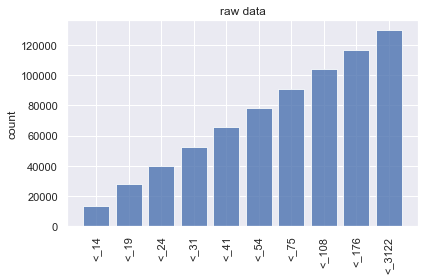

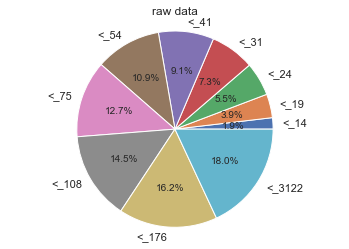

In [179]:
plot_bins(grouped_raw_dict, grouped_raw['c_o_c'].sum(), "raw data")

### Train

In [127]:
train_df = train.groupby('userId').size().reset_index(name='cont')
train_df = train_df.drop('userId', 1)
train_df = train_df.sort_values(by=['cont'])
train_df['colFromIndex'] = train_df.index
train_df = train_df.sort_values(by=['cont', 'colFromIndex'])
train_df.head(10)

,cont,colFromIndex
33,6,33
140,6,140
219,6,219
257,6,257
276,6,276
303,6,303
329,6,329
366,6,366
367,6,367
376,6,376


In [128]:
grouped_train = train_df.groupby('cont').size().reset_index(name='c_o_c')
grouped_train_dict = dict(zip(grouped_train.cont, grouped_train.c_o_c))

In [129]:
grouped_train.head()

,cont,c_o_c
0,6,2293
1,7,2497
2,8,2777
3,9,5886
4,10,3065


In [130]:
grouped_train.head()

,cont,c_o_c
0,6,2293
1,7,2497
2,8,2777
3,9,5886
4,10,3065


did 10.0  %
did 20.0  %
did 30.000000000000004  %
did 40.0  %
did 50.0  %
did 60.00000000000001  %
did 70.0  %
did 80.0  %
did 90.0  %
did 100.0  %


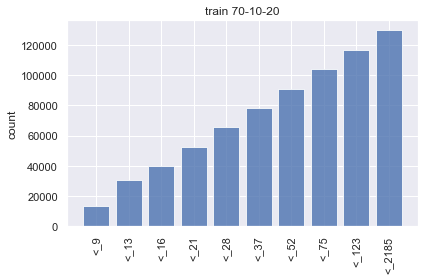

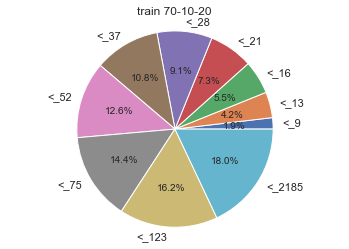

In [134]:
plot_bins(grouped_train_dict, grouped_train['c_o_c'].sum(), "train 70-10-20")

### Validation

In [135]:
val_df = val.groupby('userId').size().reset_index(name='cont')
val_df = val_df.drop('userId', 1)
val_df['colFromIndex'] = val_df.index
val_df = val_df.sort_values(by=['cont', 'colFromIndex'])
val_df.head(10)

,cont,colFromIndex
3,1,3
5,1,5
8,1,8
14,1,14
19,1,19
33,1,33
35,1,35
41,1,41
43,1,43
54,1,54


In [136]:
grouped_val = val_df.groupby('cont').size().reset_index(name='c_o_c')
grouped_val_dict = dict(zip(grouped_val.cont, grouped_val.c_o_c))

In [137]:
grouped_val.head()

,cont,c_o_c
0,1,19558
1,2,24245
2,3,15722
3,4,11408
4,5,8664


did 10.0  %
did 20.0  %
did 30.000000000000004  %
did 40.0  %
did 50.0  %
did 60.00000000000001  %
did 70.0  %
did 80.0  %
did 90.0  %
did 100.0  %


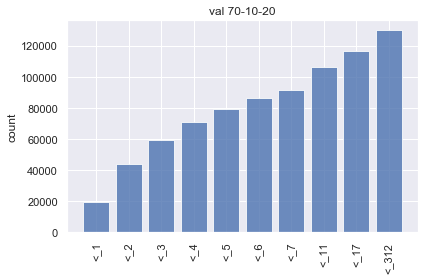

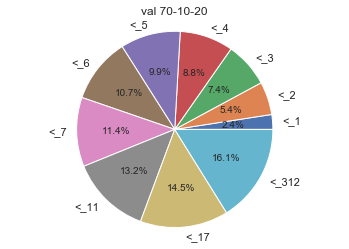

In [138]:
plot_bins(grouped_val_dict, grouped_val['c_o_c'].sum(), "val 70-10-20")

### Test

In [139]:
test.groupby('userId').size().head()
test_df = test.groupby('userId').size().reset_index(name='cont')
test_df = test_df.drop('userId', 1)
test_df['colFromIndex'] = test_df.index
test_df = test_df.sort_values(by=['cont', 'colFromIndex'])

In [140]:
grouped_test = test_df.groupby('cont').size().reset_index(name='c_o_c')
grouped_test_dict = dict(zip(grouped_test.cont, grouped_test.c_o_c))

In [141]:
grouped_test.head()

,cont,c_o_c
0,3,10489
1,4,17572
2,5,9477
3,6,11598
4,7,6246


did 10.0  %
did 20.0  %
did 30.000000000000004  %
did 40.0  %
did 50.0  %
did 60.00000000000001  %
did 70.0  %
did 80.0  %
did 90.0  %
did 100.0  %


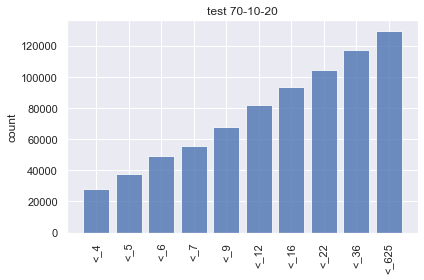

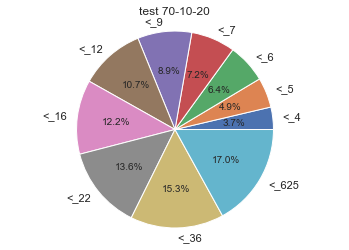

In [143]:
plot_bins(grouped_test_dict, grouped_test['c_o_c'].sum(), "test 70-10-20")

In [31]:
def plot_bins(dic,total,label, percentage_bin=0.1): 
    """Plot histogram in bins.   
    Args:
        dic: dict with keys the count and value the count of the count. e.g. user 2,3,4
        have 2 clicks, so --> 2, 3: why? the amount of times that a user has 2 clicks is 3
        percentage_bin: what is the percentage of data in each bin
        label: what to present in the label
        total: what is the total of clicks, this will be used to get the % of clicls

    Returns:
    Prints histogram and pie chart
    """
    actual_bin = 1
    value = 0
    past = 0
    bins = dict()
    for key in dic:
        value += dic[key]
        if value >= total*percentage_bin*actual_bin:
            print("did", percentage_bin * actual_bin * 100, " %" )
            k = "<_" + str(key)
            bins[k] = value
            actual_bin += 1 
            #past += value
            #value = 0
    plot_stats(bins.keys(), bins.values(), label)
    return

In [32]:
def plot_stats(labels, values, title):
    """Plot histogram and pie chart  
        Args:
            labels: labels to be used in the plots 
            values: values to be ploted
            title: title of the plots

        Returns:
        two plots
    """
    # Create arrays for the plot
    x_pos = np.arange(len(labels))
    
    # Build the plot
    fig, ax = plt.subplots()
    ax.bar(x_pos, values, align='center', alpha=0.8)
    ax.set_ylabel('count')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels, rotation=90)
    ax.set_title(title)
    ax.yaxis.grid(True)

    # Save the figure and show
    plt.tight_layout()
    plt.show()
    
    fig_pie, ax_pie = plt.subplots()
    ax_pie.pie(values, labels=labels, autopct='%1.1f%%')
    ax_pie.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
    ax_pie.set_title(title)


    plt.show()
    
    
    
    return

## Save data

In [146]:
if not os.path.exists(PARSE_DATA_DIR):
    os.makedirs(PARSE_DATA_DIR)

In [147]:
#save data in user (user_index, item_index)
def numerize(tp):
    uid = list(map(lambda x: map_user[x], tp['userId']))
    sid = list(map(lambda x: map_item[x], tp['movieId']))
    return pd.DataFrame(data={'uid': uid, 'sid': sid}, columns=['uid', 'sid'])

In [148]:
train_data = numerize(train)
train_data.to_csv(os.path.join(PARSE_DATA_DIR, 'train.csv'), index=False)

In [149]:
val_data = numerize(val)
val_data.to_csv(os.path.join(PARSE_DATA_DIR, 'validation.csv'), index=False)

In [150]:
test_data = numerize(test)
test_data.to_csv(os.path.join(PARSE_DATA_DIR, 'test.csv'), index=False)

In [151]:
#save the mappings to later use them to convert
with open(os.path.join(PARSE_DATA_DIR, 'map_user.json'), 'w') as fp:
    json.dump(map_user, fp)

In [152]:
with open(os.path.join(PARSE_DATA_DIR, 'map_item.json'), 'w') as fp:
    json.dump(map_item, fp)

In [153]:
with open(os.path.join(PARSE_DATA_DIR, 'map_item_pop.json'), 'w') as fp:
    json.dump(map_item_pop, fp)

In [154]:
with open(os.path.join(PARSE_DATA_DIR, 'unique_sid.txt'), 'w') as f:
    for sid in unique_sid:
        f.write('%s\n' % sid)

In [155]:
with open(os.path.join(PARSE_DATA_DIR, 'unique_uid.txt'), 'w') as f:
    for sid in unique_uid:
        f.write('%s\n' % sid)